In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from prophet import Prophet
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
np.set_printoptions(suppress=True, precision=2)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
symbol='AAPL'
start_date="2015-01-01"
end_date="2026-01-01"
raw_date=yf.download(symbol,
            start=start_date,
            end=end_date,
            auto_adjust=True,
            group_by='AAPL')
df=raw_date.copy()

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Ticker           AAPL                                            
Price            Open       High        Low      Close     Volume
Date                                                             
2015-01-02  24.671151  24.682226  23.776353  24.214893  212818400
2015-01-05  23.984547  24.064282  23.346673  23.532719  257142000
2015-01-06  23.596954  23.794075  23.173918  23.534939  263188400
2015-01-07  23.743135  23.964619  23.632393  23.864952  160423600
2015-01-08  24.192739  24.839473  24.075351  24.781887  237458000

In [ ]:
df.columns

MultiIndex([('AAPL',   'Open'),
            ('AAPL',   'High'),
            ('AAPL',    'Low'),
            ('AAPL',  'Close'),
            ('AAPL', 'Volume')],
           names=['Ticker', 'Price'])

In [ ]:
df['AAPL_Close']=raw_date['AAPL'].Close
df

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2015-01-02   24.671151   24.682226   23.776353   24.214893  212818400   
2015-01-05   23.984547   24.064282   23.346673   23.532719  257142000   
2015-01-06   23.596954   23.794075   23.173918   23.534939  263188400   
2015-01-07   23.743135   23.964619   23.632393   23.864952  160423600   
2015-01-08   24.192739   24.839473   24.075351   24.781887  237458000   
...                ...         ...         ...         ...        ...   
2025-12-24  272.085389  275.172497  271.945536  273.554016   17910600   
2025-12-26  273.903708  275.112569  272.604905  273.144409   21521800   
2025-12-29  272.435082  274.103504  272.095404  273.504089   23715200   
2025-12-30  272.554970  273.823772  272.025467  272.824707   22139600   
2025-12-31  272.804725  273.424141  271.495952  271.605835   27293600   

Ticker      AAPL_Close  
Price                   
Date                    
2015-01-02   24.214893  
2015-01-05   23.532719  
2015-01-06   23.534939  
2015-01-07   23.864952  
2015-01-08   24.781887  
...                ...  
2025-12-24  273.554016  
2025-12-26  273.144409  
2025-12-29  273.504089  
2025-12-30  272.824707  
2025-12-31  271.605835  

[2766 rows x 6 columns]

In [ ]:
df['AAPL_Close']

,AAPL_Close
Date,
2015-01-02,24.214893
2015-01-05,23.532719
2015-01-06,23.534939
2015-01-07,23.864952
2015-01-08,24.781887
...,...
2025-12-24,273.554016
2025-12-26,273.144409
2025-12-29,273.504089


In [ ]:
df['AAPL_Close_Return']=df['AAPL_Close'].pct_change(1).mul(100)
df['AAPL_Close_Return_Squared']=df['AAPL_Close_Return'].mul(df['AAPL_Close_Return'])

In [ ]:
df=df.asfreq('b')
df=df.fillna(method='bfill')

In [ ]:
size=int(len(df)*0.8)
df_train,df_test=df.iloc[:size],df.iloc[size:]
df_train_10,df_test_10 =df.iloc[:-10],df[-10:]

In [ ]:
df_test

Ticker            AAPL                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2023-10-20  173.279209  173.387935  170.640140  170.877365  64244000.0   
2023-10-23  168.930201  171.994282  167.961542  170.995987  55980100.0   
2023-10-24  171.045411  171.658224  169.463939  171.430893  43816600.0   
2023-10-25  169.888975  171.055299  168.673212  169.118011  57157000.0   
2023-10-26  168.396440  169.394750  163.750888  164.956757  70625300.0   
...                ...         ...         ...         ...         ...   
2025-12-25  273.903708  275.112569  272.604905  273.144409  21521800.0   
2025-12-26  273.903708  275.112569  272.604905  273.144409  21521800.0   
2025-12-29  272.435082  274.103504  272.095404  273.504089  23715200.0   
2025-12-30  272.554970  273.823772  272.025467  272.824707  22139600.0   
2025-12-31  272.804725  273.424141  271.495952  271.605835  27293600.0   

Ticker      AAPL_Close AAPL_Close_Return AAPL_Close_Return_Squared  
Price                                                               
Date                                                                
2023-10-20  170.877365         -1.470436                  2.162182  
2023-10-23  170.995987          0.069419                  0.004819  
2023-10-24  171.430893          0.254337                  0.064687  
2023-10-25  169.118011         -1.349163                  1.820240  
2023-10-26  164.956757         -2.460563                  6.054369  
...                ...               ...                       ...  
2025-12-25  273.144409         -0.149735                  0.022421  
2025-12-26  273.144409         -0.149735                  0.022421  
2025-12-29  273.504089          0.131681                  0.017340  
2025-12-30  272.824707         -0.248399                  0.061702  
2025-12-31  271.605835         -0.446760                  0.199595  

[574 rows x 8 columns]

In [ ]:
print(f"Total data points: {len(df)}")
print(f"Training set: {len(df_train)}")
print(f"Test set: {len(df_test)}")
print(f"\nTraining period: {df_train.index[0]} to {df_train.index[-1]}")
print(f"Test period: {df_test.index[0]} to {df_test.index[-1]}")

Total data points: 2869
Training set: 2295
Test set: 574

Training period: 2015-01-02 00:00:00 to 2023-10-19 00:00:00
Test period: 2023-10-20 00:00:00 to 2025-12-31 00:00:00


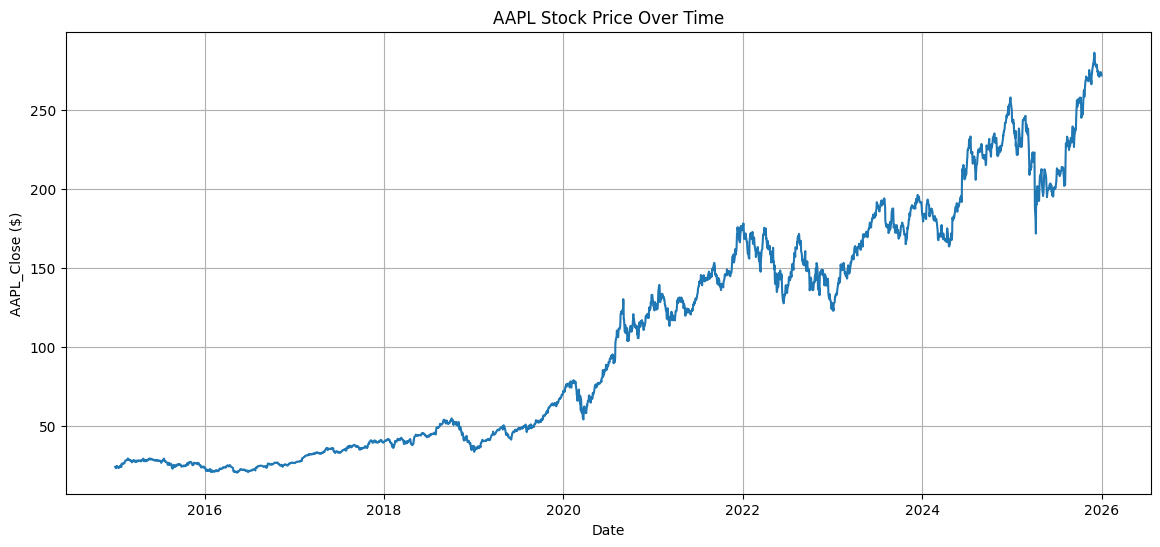

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['AAPL_Close'])
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('AAPL_Close ($)')
plt.grid(True)
plt.savefig('price_plot.png')
plt.show()

In [ ]:
seasonal_decompose(df['AAPL_Close'])

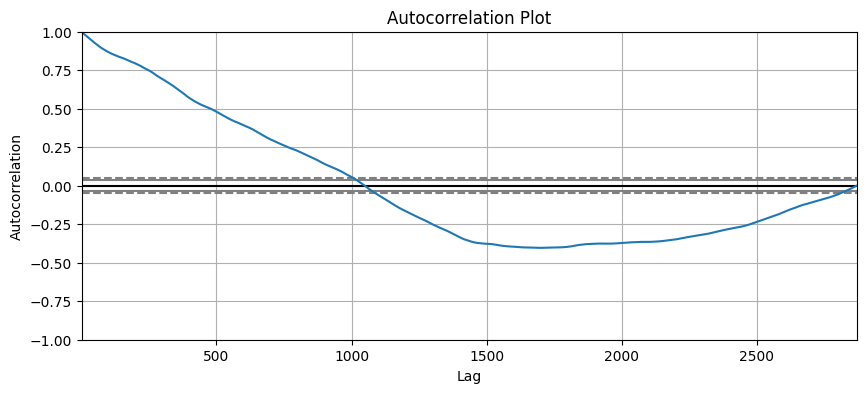

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['AAPL_Close'])
plt.title('Autocorrelation Plot')
plt.savefig('autocorrelation.png')
plt.show()

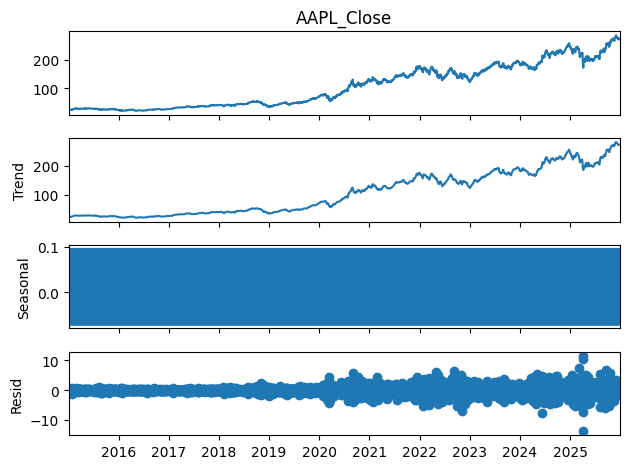

In [ ]:
decomposition=seasonal_decompose(df['AAPL_Close'],
                   model="additive")
decomposition.plot()
plt.show()



## 🔹 Panel 1: Original Series (`AAPL_Close`)

* Shows the **actual daily closing prices** of Apple from 2015 → 2025.
* Observations:

  * Clear **upward trend** over 10 years (from ~$30 to ~$250+).
  * Some **sharp drops** (2020 COVID dip, market corrections in 2022–2023).
  * Highly **non-stationary** (mean and variance increase over time).

## 🔹 Panel 2: Trend

* Smooth version of the original series.
* Observations:

  * Captures the **long-term growth** of Apple stock.
  * Volatility in 2020–2023 is **smoothed out**, showing general upward trajectory.
  * Trend component dominates the time series — this is typical for **stocks with strong growth**.



## 🔹 Panel 3: Seasonal

* Completely **flat at 0**.

* Interpretation:

  * **No obvious seasonality** in Apple stock daily closing prices.
  * Stock markets don’t usually follow fixed seasonal cycles in daily prices.
  * Seasonal component would be more visible in:

* Insight: You **don’t need SARIMA**; plain ARIMA is sufficient.

---

## 🔹 Panel 4: Residual (`Resids`)

* Shows **what’s left after removing trend and seasonal components**.

* Observations:

  * Contains **high volatility periods**, e.g., 2020–2023.
  * Residuals fluctuate randomly around 0.
  * Some **large spikes**, which are market shocks (COVID, corrections).

* Insight:

  * Residuals are basically **noise**, but LSTM can try to capture patterns in residual spikes.
  * ARIMA models will treat this as **random fluctuations**.

---

## ✅ Key Takeaways / Insights

1. **Strong Trend**

   * Apple stock has a clear **long-term upward trend**.
   * Most of the series’ movement is trend-driven.

2. **No Daily Seasonality**

   * Seasonal decomposition confirms **flat seasonal component**.
   * Using SARIMA is unnecessary; simple ARIMA is enough.

3. **Volatile Residuals**

   * Random spikes indicate **market shocks**, which are unpredictable.
   * LSTM may capture some short-term patterns here.

4. **Implications for Forecasting**

   * For ARIMA:

     * Use **first difference** to remove non-stationarity.
   * For LSTM:

     * Feed trend + residuals to capture **both long-term and short-term dependencies**.
   * Avoid adding “seasonal” components — daily Apple prices don’t repeat predictably.



# 🧠 Hypotheses of ADF Test
 - Null Hypothesis (H₀)

   - The time series has a unit root
   - → Non-stationary

 - Alternative Hypothesis (H₁)
   - The time series does NOT have a unit root
   - → Stationary

 - Decision Rule:
   - If p_value < 0.5 Then Reject H0 (Time Series is Stationary)

In [ ]:
adfuller_test_close=adfuller(df['AAPL_Close'])
p_value_close=adfuller_test_close[1]
if p_value_close<0.05:
    print('Time Series is Stationary')
else:
    print('Time Series is Not Stationary')

Time Series is Not Stationary


In [ ]:
adfuller_test_return=adfuller(df['AAPL_Close_Return'])
p_value_return=adfuller_test_return[1]
if p_value_return<0.05:
    print('Time Series is Stationary')
else:
    print('Time Series is Not Stationary')

Time Series is Stationary


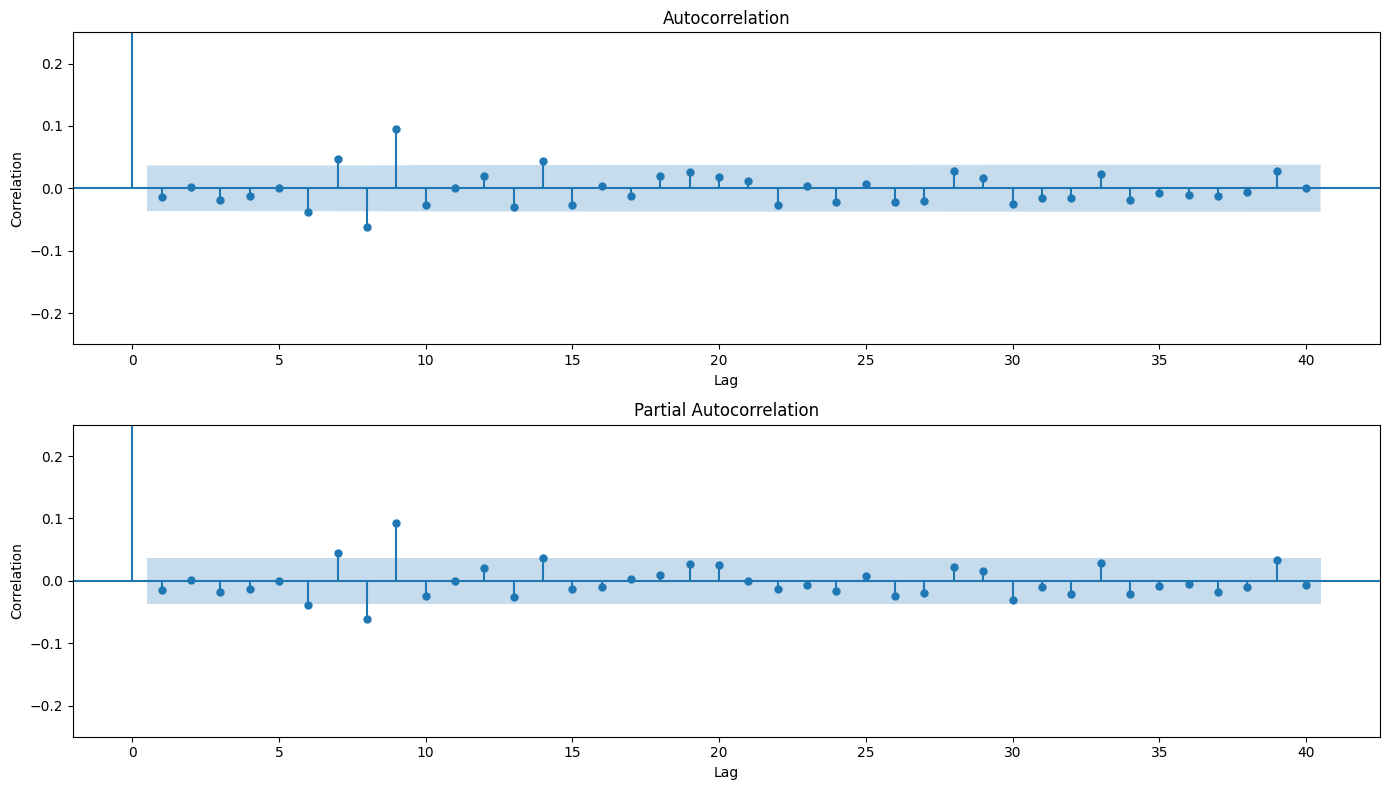

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(df['AAPL_Close_Return'][1:],lags=40,ax=axes[0])
plot_pacf(df['AAPL_Close_Return'][1:],lags=40,ax=axes[1])
axes[0].set_ylim([-0.25,0.25])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[1].set_ylim([-0.25,0.25])
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Correlation')
plt.tight_layout()
plt.show()

In [ ]:
simple_model=ARIMA(df_train['AAPL_Close_Return'],
             order=(1,0,1))
simple_result=simple_model.fit()
simple_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      AAPL_Close_Return   No. Observations:                 2295
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4660.248
Date:                Sat, 14 Feb 2026   AIC                           9328.497
Time:                        11:24:46   BIC                           9351.451
Sample:                    01-02-2015   HQIC                          9336.866
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1008      0.038      2.636      0.008       0.026       0.176
ar.L1          0.3703      0.295      1.254      0.210      -0.208       0.949
ma.L1         -0.4077      0.293     -1.390      0.165      -0.983       0.167
sigma2         3.3989      0.057     59.552      0.000       3.287       3.511
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2260.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

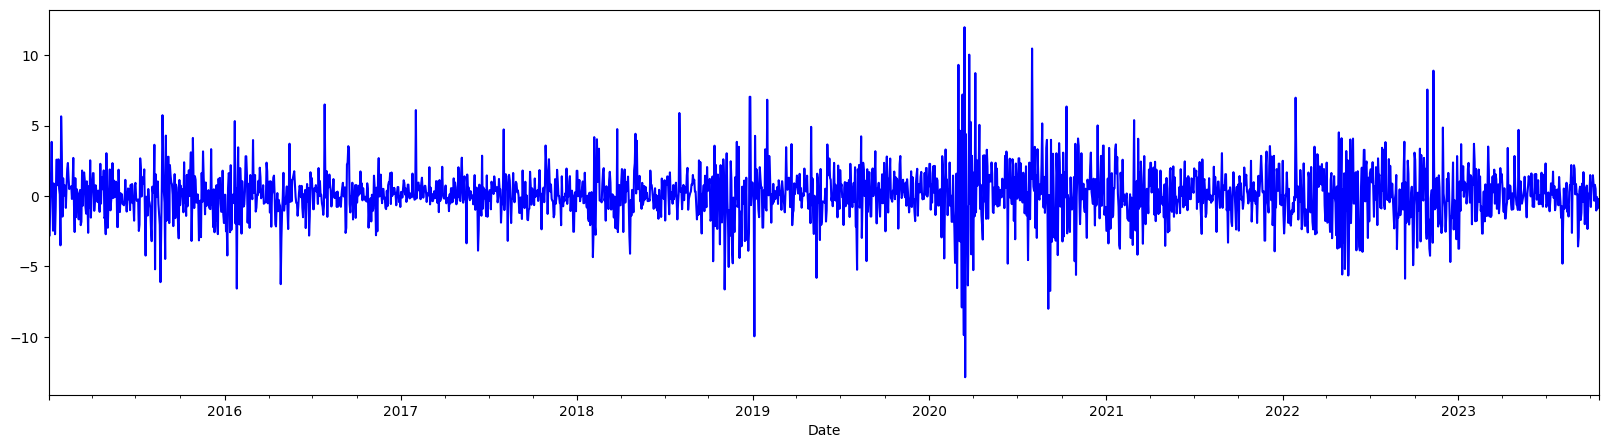

In [ ]:
df_train['AAPL_Close_Return'].plot(figsize = (20,5), color = "blue")



In [ ]:
# df_pred_ar.plot(figsize = (20,5), color = "red")

In [ ]:
df_train


Ticker            AAPL                                                   \
Price             Open        High         Low       Close       Volume   
Date                                                                      
2015-01-02   24.671151   24.682226   23.776353   24.214893  212818400.0   
2015-01-05   23.984547   24.064282   23.346673   23.532719  257142000.0   
2015-01-06   23.596954   23.794075   23.173918   23.534939  263188400.0   
2015-01-07   23.743135   23.964619   23.632393   23.864952  160423600.0   
2015-01-08   24.192739   24.839473   24.075351   24.781887  237458000.0   
...                ...         ...         ...         ...          ...   
2023-10-13  179.318450  179.822537  176.076447  176.778229   51427100.0   
2023-10-16  174.702538  177.005550  174.465313  176.649719   52517000.0   
2023-10-17  174.603677  176.353178  172.775117  175.097885   57549400.0   
2023-10-18  173.546103  175.522935  173.081546  173.803085   54764400.0   
2023-10-19  174.000774  175.779926  173.160629  173.427505   59302900.0   

Ticker      AAPL_Close AAPL_Close_Return AAPL_Close_Return_Squared  
Price                                                               
Date                                                                
2015-01-02   24.214893         -2.817170                  7.936446  
2015-01-05   23.532719         -2.817170                  7.936446  
2015-01-06   23.534939          0.009434                  0.000089  
2015-01-07   23.864952          1.402227                  1.966241  
2015-01-08   24.781887          3.842182                 14.762365  
...                ...               ...                       ...  
2023-10-13  176.778229         -1.029283                  1.059423  
2023-10-16  176.649719         -0.072695                  0.005285  
2023-10-17  175.097885         -0.878481                  0.771729  
2023-10-18  173.803085         -0.739472                  0.546819  
2023-10-19  173.427505         -0.216095                  0.046697  

[2295 rows x 8 columns]

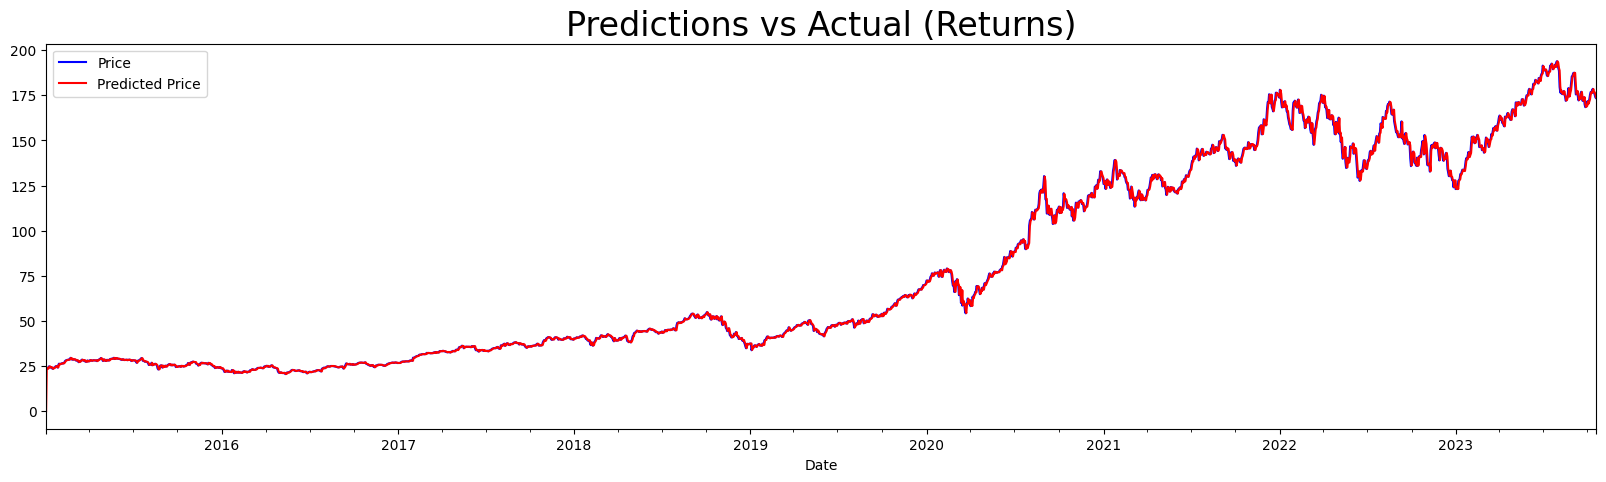

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2295
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4533.441
Date:                Sat, 14 Feb 2026   AIC                           9072.883
Time:                        11:24:49   BIC                           9090.097
Sample:                    01-02-2015   HQIC                          9079.160
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4727      0.210      2.254      0.024       0.062       0.884
ma.L1         -0.5128      0.206     -2.490      0.013      -0.916      -0.109
sigma2         3.0482      0.044     69.675      0.000       2.962       3.134
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4385.77
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              44.70   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df_train['AAPL'].Close, order = (1,1,1))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict()

df_train['AAPL'].Close.plot(figsize = (20,5), color = "blue",label='Price')
df_pred_ar.plot(figsize = (20,5), color = "red",label='Predicted Price')

# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()
results_ret_ar.summary()


In [ ]:
df_train['AAPL'].Close.values

array([ 24.21489334,  23.53271866,  23.53493881, ..., 175.09788513,
       173.80308533, 173.42750549])

In [ ]:
df_pred_ar

,predicted_mean
Date,
2015-01-02,0.000000
2015-01-05,24.214890
2015-01-06,23.559349
2015-01-07,23.548498
2015-01-08,23.858695
...,...
2023-10-13,178.540519
2023-10-16,176.812887
2023-10-17,176.672644


In [ ]:
np.concatenate((df_train['AAPL'].Close.values.reshape(-1,1),df_pred_ar.values.reshape(-1,1)),1)

array([[ 24.21489334,   0.        ],
       [ 23.53271866,  24.21489045],
       [ 23.53493881,  23.55934888],
       ...,
       [175.09788513, 176.67264386],
       [173.80308533, 175.17186706],
       [173.42750549, 173.89294113]])

## Hyperparameter Optimization: Grid Search for ARIMA (p, d, q)

In [ ]:
p_range=range(1,7)
q_range=range(1,7)
result=[]
best_aic=float('inf')
best_order=None
best_model=None
y=df_train_10['AAPL_Close']
for p in  p_range:
    for q in q_range:
        model_prices =ARIMA(y,order=(p,1,q))
        result=model_prices.fit()
        aic =result.aic
        llf=result.llf
        y_predict=result.predict()
        y_aligned,pred_aligned=y.align(y_predict,join='inner')
        rmse=np.sqrt(mean_squared_error(y_aligned[1:],pred_aligned[1:]))
        result.append([p,q,aic,llf,rmse])
        print(f"ARIMA({p},1,{q}) | AIC: {aic:.2f} | LogLik: {llf:.2f} | RMSE: {rmse:.2f}")
        if aic <best_aic:
            best_aic=aic
            best_order=(p,1,q)
            best_model=result

ARIMA(1,1,1) | AIC: 12635.60 | LogLik: -6314.80 | RMSE: 2.20
ARIMA(1,1,2) | AIC: 12635.00 | LogLik: -6313.50 | RMSE: 2.20
ARIMA(1,1,3) | AIC: 12630.42 | LogLik: -6310.21 | RMSE: 2.20
ARIMA(1,1,4) | AIC: 12636.39 | LogLik: -6312.20 | RMSE: 2.20
ARIMA(1,1,5) | AIC: 12637.51 | LogLik: -6311.75 | RMSE: 2.20
ARIMA(1,1,6) | AIC: 12619.59 | LogLik: -6301.79 | RMSE: 2.19
ARIMA(2,1,1) | AIC: 12635.27 | LogLik: -6313.63 | RMSE: 2.20
ARIMA(2,1,2) | AIC: 12616.04 | LogLik: -6303.02 | RMSE: 2.20
ARIMA(2,1,3) | AIC: 12632.42 | LogLik: -6310.21 | RMSE: 2.20
ARIMA(2,1,4) | AIC: 12634.42 | LogLik: -6310.21 | RMSE: 2.20
ARIMA(2,1,5) | AIC: 12625.34 | LogLik: -6304.67 | RMSE: 2.20
ARIMA(2,1,6) | AIC: 12617.51 | LogLik: -6299.76 | RMSE: 2.19
ARIMA(3,1,1) | AIC: 12630.25 | LogLik: -6310.13 | RMSE: 2.20
ARIMA(3,1,2) | AIC: 12632.21 | LogLik: -6310.11 | RMSE: 2.20
ARIMA(3,1,3) | AIC: 12634.00 | LogLik: -6310.00 | RMSE: 2.20
ARIMA(3,1,4) | AIC: 12636.42 | LogLik: -6310.21 | RMSE: 2.20
ARIMA(3,1,5) | AIC: 1260

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             AAPL_Close   No. Observations:                 2859
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -6294.301
Date:                Sat, 14 Feb 2026   AIC                          12606.603
Time:                        11:27:38   BIC                          12660.224
Sample:                    01-02-2015   HQIC                         12625.938
                         - 12-17-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0191      0.011     -1.726      0.084      -0.041       0.003
ar.L2          1.8444      0.011    171.334      0.000       1.823       1.865
ar.L3         -0.0713      0.010     -7.233      0.000      -0.091      -0.052
ar.L4         -0.9670      0.010    -92.529      0.000      -0.988      -0.947
ma.L1          0.0237      0.011      2.084      0.037       0.001       0.046
ma.L2         -1.8558      0.011   -165.173      0.000      -1.878      -1.834
ma.L3          0.0667      0.011      6.280      0.000       0.046       0.087
ma.L4          0.9713      0.011     85.834      0.000       0.949       0.993
sigma2         4.8074      0.053     91.218      0.000       4.704       4.911
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             24421.10
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              54.04   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Compare Actual price with Prediction price for trian data

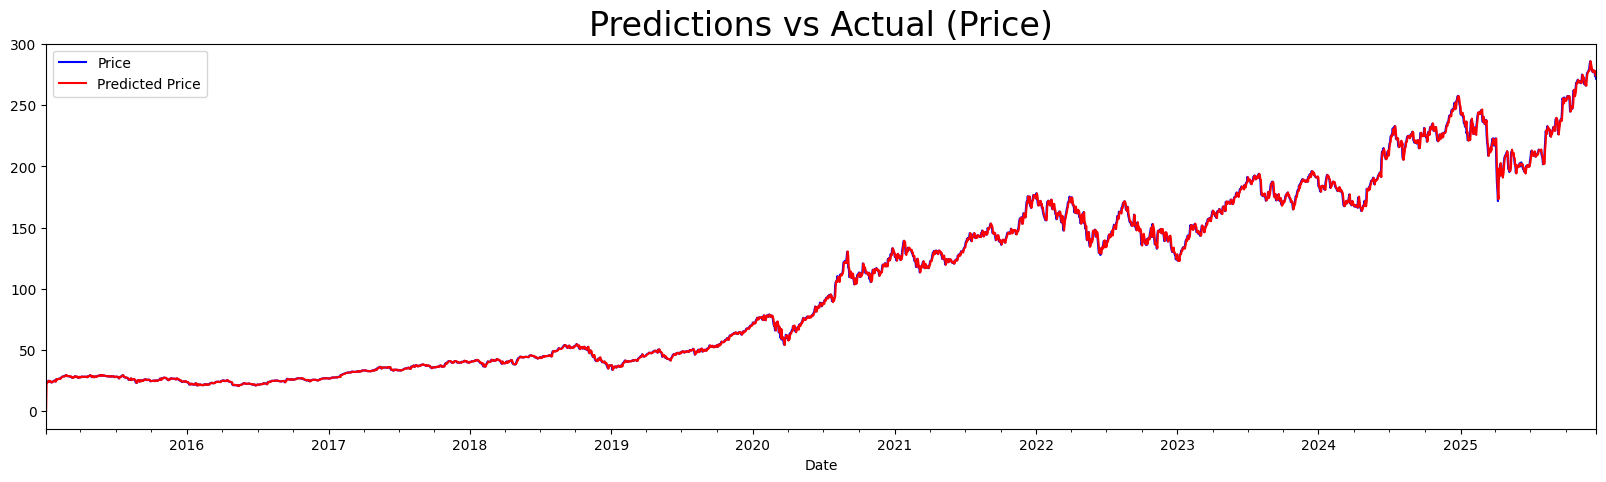

In [ ]:
df_train_10['AAPL_Close'].plot(figsize = (20,5), color = "blue",label='Actual Price')
y_predict.plot(figsize = (20,5), color = "red",label='Predicted Price')

# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Price)", size = 24)
plt.legend()
plt.show()

In [ ]:
predicted_return_6_1_5=y_predict.pct_change(1).mul(100)


## Compare Actual price with Prediction price for trian data

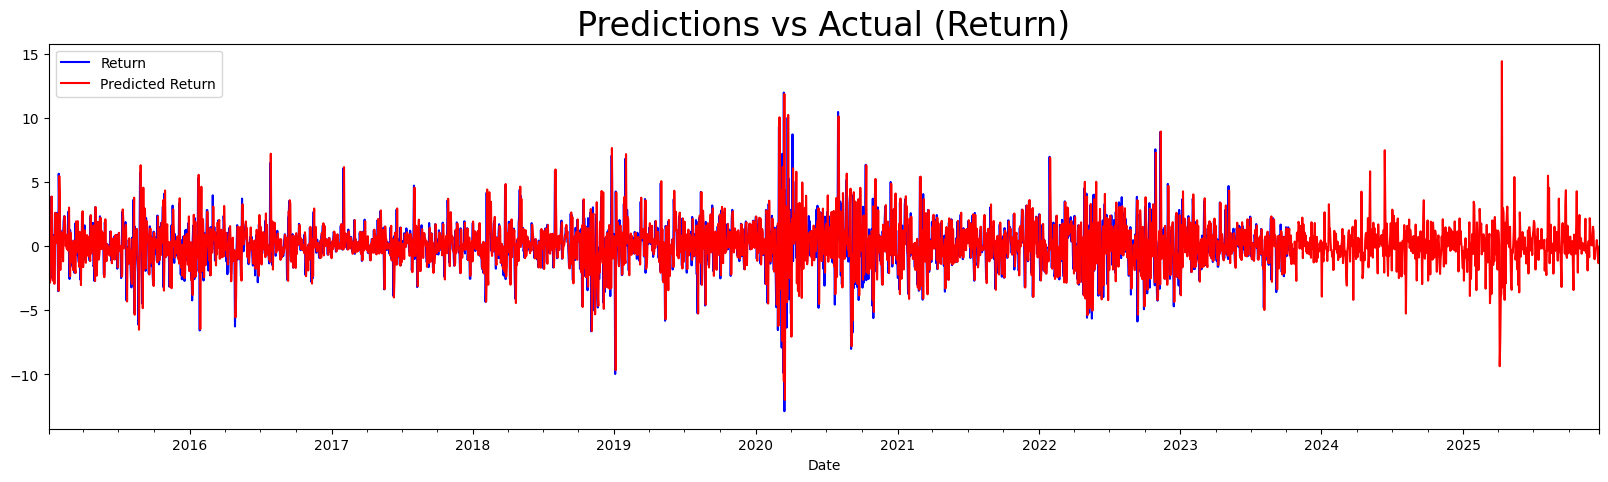

In [ ]:
df_train['AAPL_Close_Return'].plot(figsize = (20,5), color = "blue",label='Return')
predicted_return_6_1_5.plot(figsize = (20,5), color = "red",label='Predicted Return')

# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Return)", size = 24)
plt.legend()
plt.show()

In [ ]:
# Forecaste price of test data
forecasted_price_6_1_5=best_model.forecast(steps=(len(df_test_10['AAPL_Close'])))
len(forecasted_price_6_1_5),len(df_test_10['AAPL_Close'])

(10, 10)

## Compare predictions of Actual price and Forecasted price for test data

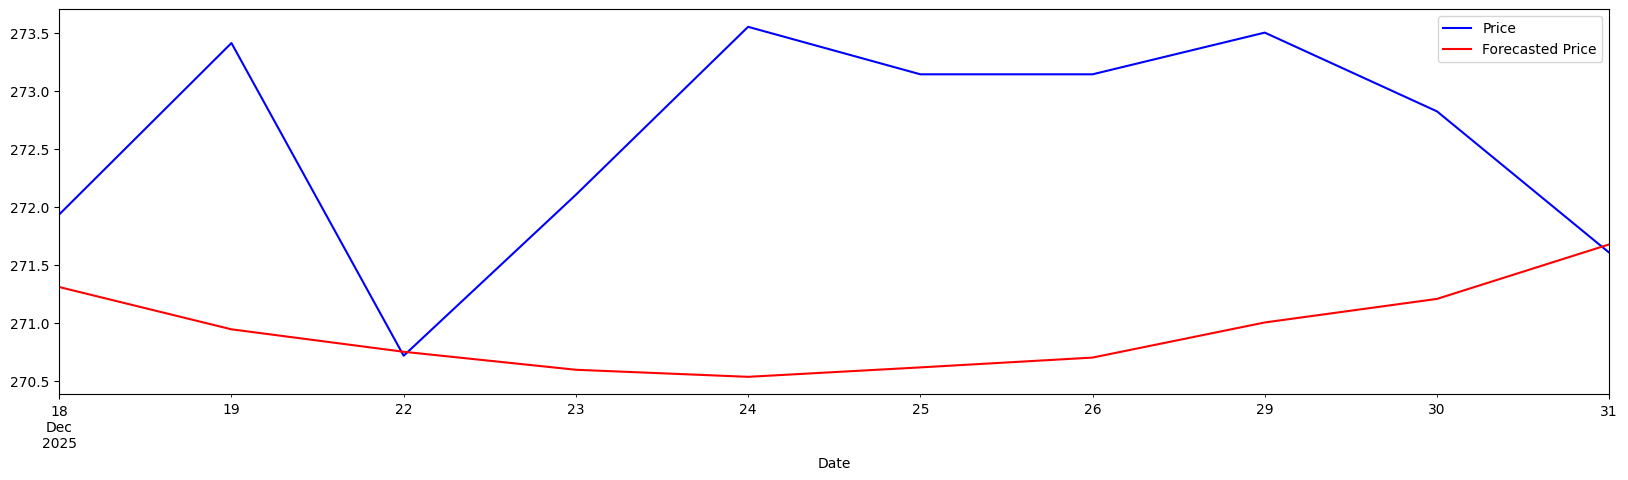

In [ ]:
df_test_10['AAPL_Close'].plot(figsize = (20,5), color = "blue",label='Price')
forecasted_price_6_1_5.plot(figsize = (20,5), color = "red",label='Forecasted Price')
plt.legend()

In [ ]:
p_range=range(1,7)
q_range=range(1,7)
result=[]
best_aic=float('inf')
best_order=None
best_model=None
y=df_train_10['AAPL_Close_Return']
for p in  p_range:
    for q in q_range:
        model_returns =ARIMA(y,order=(p,0,q))
        result=model_returns.fit()
        aic =result.aic
        llf=result.llf
        y_predict=result.predict()
        y_aligned,pred_aligned=y.align(y_predict,join='inner')
        rmse=np.sqrt(mean_squared_error(y_aligned[1:],pred_aligned[1:]))
        result.append([p,q,aic,llf,rmse])
        print(f"ARIMA({p},1,{q}) | AIC: {aic:.2f} | LogLik: {llf:.2f} | RMSE: {rmse:.2f}")
        if aic <best_aic:
            best_aic=aic
            best_order=(p,1,q)
            best_model=result

ARIMA(1,1,1) | AIC: 11553.15 | LogLik: -5772.57 | RMSE: 1.82
ARIMA(1,1,2) | AIC: 11554.62 | LogLik: -5772.31 | RMSE: 1.82
ARIMA(1,1,3) | AIC: 11548.68 | LogLik: -5768.34 | RMSE: 1.82
ARIMA(1,1,4) | AIC: 11557.69 | LogLik: -5771.85 | RMSE: 1.82
ARIMA(1,1,5) | AIC: 11546.35 | LogLik: -5765.17 | RMSE: 1.82
ARIMA(1,1,6) | AIC: 11540.31 | LogLik: -5761.15 | RMSE: 1.81
ARIMA(2,1,1) | AIC: 11555.22 | LogLik: -5772.61 | RMSE: 1.82
ARIMA(2,1,2) | AIC: 11551.45 | LogLik: -5769.72 | RMSE: 1.82
ARIMA(2,1,3) | AIC: 11553.88 | LogLik: -5769.94 | RMSE: 1.82
ARIMA(2,1,4) | AIC: 11521.78 | LogLik: -5752.89 | RMSE: 1.81
ARIMA(2,1,5) | AIC: 11521.52 | LogLik: -5751.76 | RMSE: 1.81
ARIMA(2,1,6) | AIC: 11517.94 | LogLik: -5748.97 | RMSE: 1.81
ARIMA(3,1,1) | AIC: 11555.52 | LogLik: -5771.76 | RMSE: 1.82
ARIMA(3,1,2) | AIC: 11550.79 | LogLik: -5768.40 | RMSE: 1.82
ARIMA(3,1,3) | AIC: 11535.71 | LogLik: -5759.85 | RMSE: 1.81
ARIMA(3,1,4) | AIC: 11528.92 | LogLik: -5755.46 | RMSE: 1.81
ARIMA(3,1,5) | AIC: 1152

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      AAPL_Close_Return   No. Observations:                 2859
Model:                 ARIMA(2, 0, 6)   Log Likelihood               -5748.970
Date:                Sat, 14 Feb 2026   AIC                          11517.940
Time:                        11:32:13   BIC                          11577.523
Sample:                    01-02-2015   HQIC                         11539.425
                         - 12-17-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0937      0.034      2.744      0.006       0.027       0.161
ar.L1         -1.5525      0.052    -29.757      0.000      -1.655      -1.450
ar.L2         -0.7761      0.050    -15.558      0.000      -0.874      -0.678
ma.L1          1.5528      0.054     28.960      0.000       1.448       1.658
ma.L2          0.7683      0.055     13.911      0.000       0.660       0.877
ma.L3         -0.0302      0.027     -1.133      0.257      -0.082       0.022
ma.L4         -0.0412      0.025     -1.655      0.098      -0.090       0.008
ma.L5         -0.0347      0.026     -1.348      0.178      -0.085       0.016
ma.L6         -0.0526      0.017     -3.116      0.002      -0.086      -0.020
sigma2         3.2666      0.052     63.175      0.000       3.165       3.368
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3638.04
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

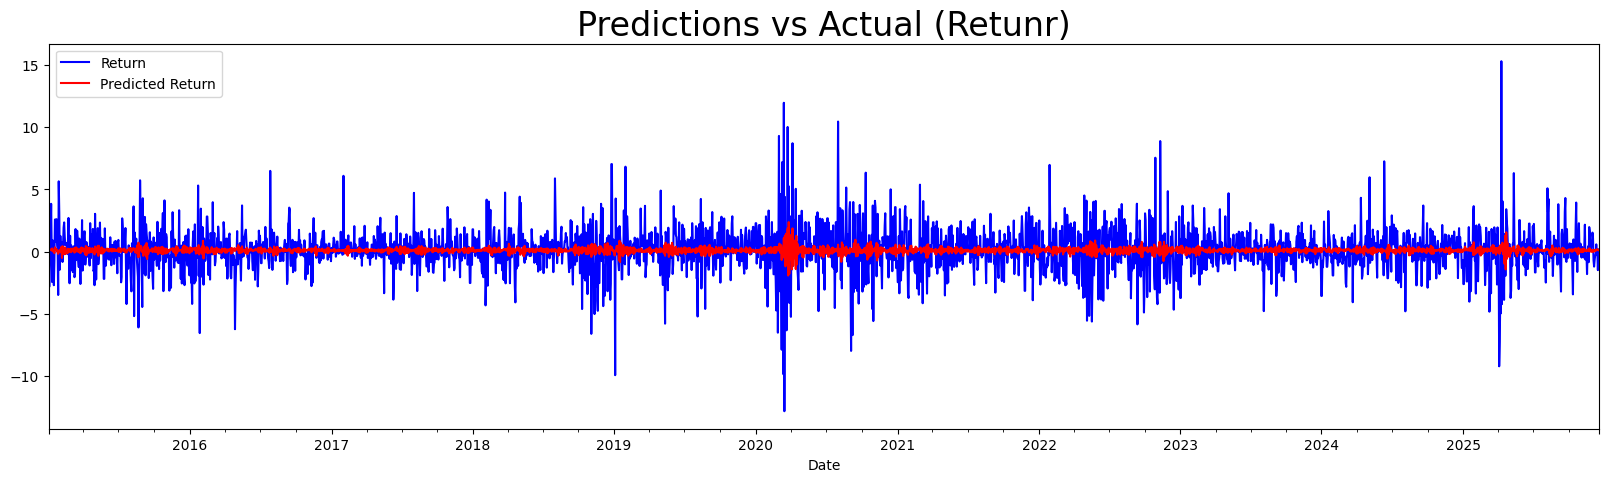

In [ ]:
df_train_10['AAPL_Close_Return'].plot(figsize = (20,5), color = "blue",label='Return')
y_predict.plot(figsize = (20,5), color = "red",label='Predicted Return')

# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Retunr)", size = 24)
plt.legend()
plt.show()

In [ ]:
last_price = df['AAPL_Close'].iloc[len(df_train_10)]
predicted_prices = [last_price]

for r in y_predict:
    next_price = predicted_prices[-1] * (1 + r/100)
    predicted_prices.append(next_price)

In [ ]:
R_decimal = y_predict / 100
y_predict_price= df_train_10['AAPL_Close'].iloc[0] * (1 + R_decimal).cumprod()

y_predict_price

,predicted_mean
Date,
2015-01-02,24.237361
2015-01-05,24.267786
2015-01-06,24.298967
2015-01-07,24.339825
2015-01-08,24.380009
...,...
2025-12-11,338.072906
2025-12-12,338.497039
2025-12-15,339.001748


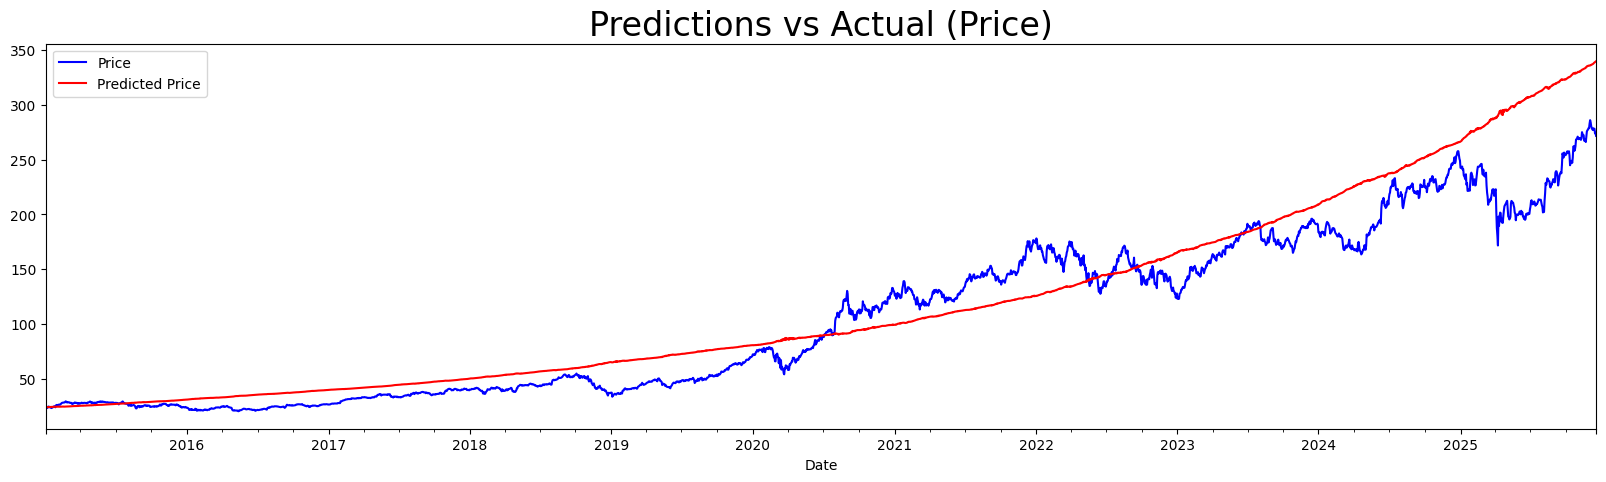

In [ ]:
df_train_10['AAPL'].Close.plot(figsize = (20,5), color = "blue",label='Price')
y_predict_price.plot(figsize = (20,5), color = "red",label='Predicted Price')

# df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Price)", size = 24)
plt.legend()
plt.show()

In [ ]:
y_predict_price

Date
2015-01-02     24.237545
2015-01-05     24.269106
2015-01-06     24.301736
2015-01-07     24.341748
2015-01-08     24.379311
                 ...    
2025-12-11    345.862720
2025-12-12    346.287597
2025-12-15    346.803937
2025-12-16    347.141645
2025-12-17    347.474651
Freq: B, Name: predicted_mean, Length: 2859, dtype: float64

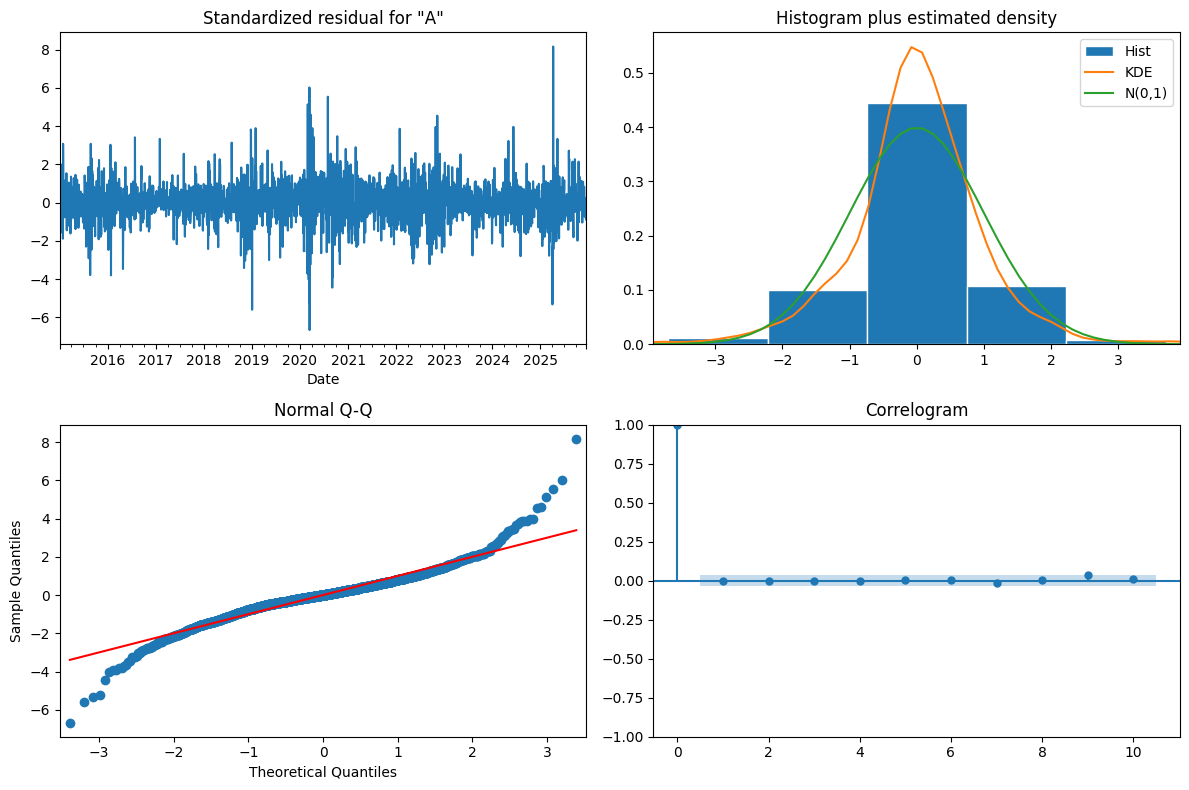

In [ ]:
best_model.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()



### Standardized residuals:
 - Early periods (2015-2018) have small variance
 - Later periods (2020-2023) have much larger variance
 - Residual Variance is not Constant
 - Then ARIMA model captures the mean structure well but fails to model changing volatility
### Histogram +KDE:
 - Symmetric bell Shape
 - Centered at zero
 - Tails are heavier than Normal Distribution
 - ARIMA assume Gaussian errors but data violates this assumption slightly
### Normal Q-Q Plot
- Points in middle lie very close to red line
- Points in tails have storng Deviation
- Model have extreme positive and negative residuals
- Then ARIMA model is good for average behaviour but underestimates extreme moves
### ACF of Residuals(Correlogram):
 - All bars inside confidence region this mean no significant autocorrelation
 - No visible pattern
 - Residuals are uncorrelated
 - This mean mean dynamics are fully caputred


In [ ]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
n_steps=len(df_test_10['AAPL_Close_Return'])
n_steps

10

In [ ]:
y_steps=len(df_test_10['AAPL_Close'])
y_forcast=best_model.forecast(steps=y_steps)
print('length of y_test',len(df_test_10['AAPL_Close']))
print('length of y_forcast',len(y_forcast))

length of y_test 10
length of y_forcast 10


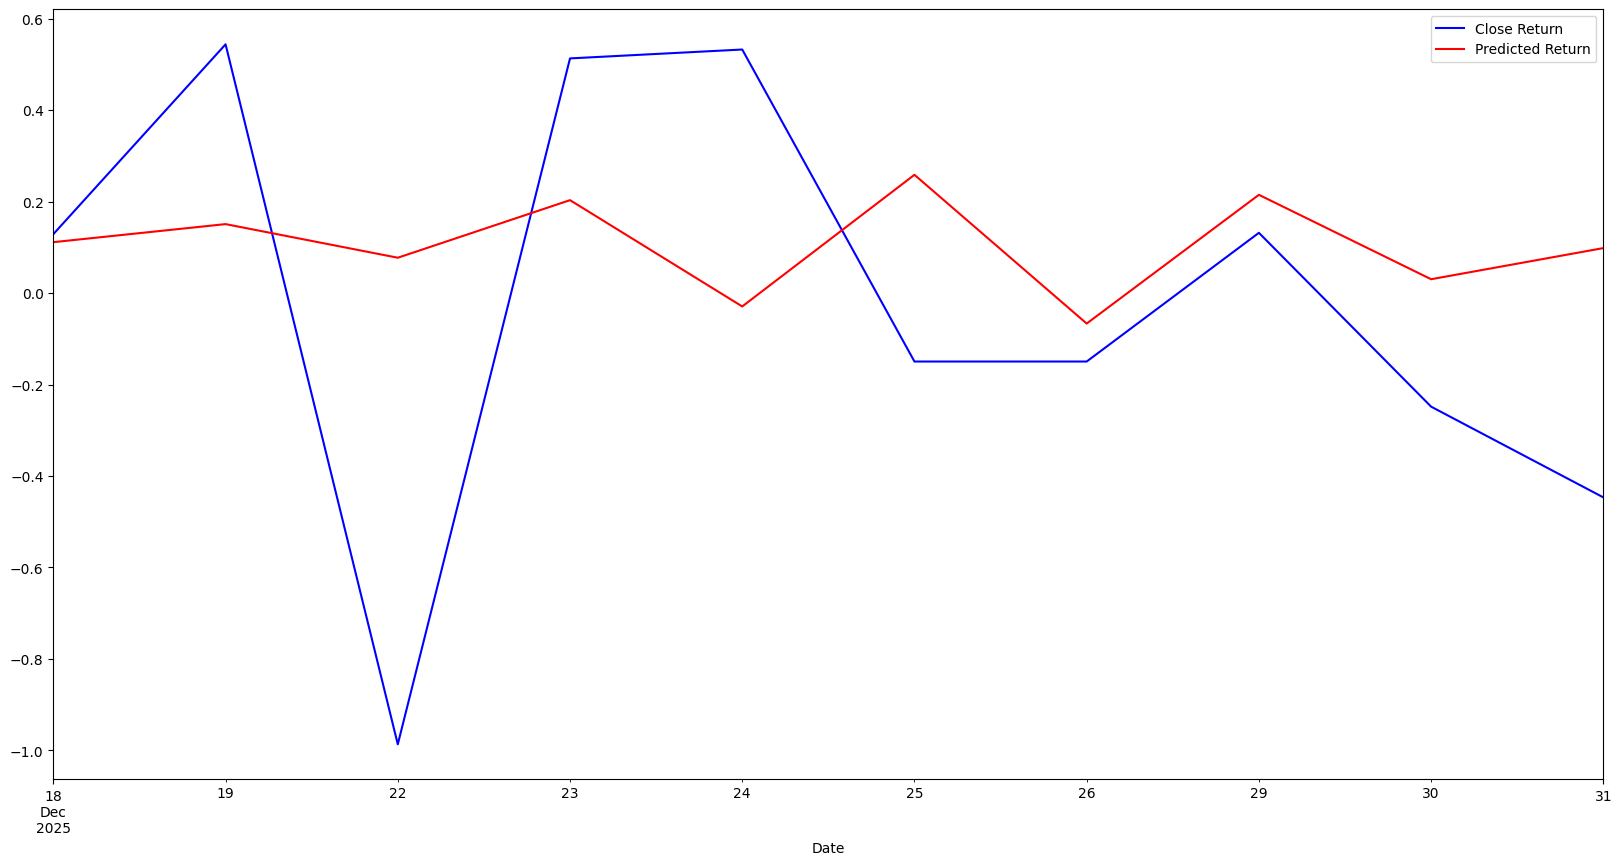

In [ ]:
df_test_10['AAPL_Close_Return'].plot(color='blue',label='Close Return',figsize=(20,10))
y_forcast.plot(color='red',label='Predicted Return',figsize=(20,10))
plt.legend()
plt.show()

In [ ]:
# 1. Use the LAST price of your training set as the base
anchor_price = df_train_10['AAPL_Close'].iloc[-1]

# 2. Convert percentage returns to growth decimals (e.g., 0.5% -> 1.005)
growth_factors = (y_forcast / 100) + 1

# 3. Use cumprod to chain them together and multiply by the anchor
y_forecast_prices = anchor_price * growth_factors.cumprod()
y_forecast_prices

,predicted_mean
2025-12-18,271.887920
2025-12-19,272.297599
2025-12-22,272.507792
2025-12-23,273.061194
2025-12-24,272.981081
2025-12-25,273.686700
2025-12-26,273.504135
2025-12-29,274.091478
2025-12-30,274.174252
2025-12-31,274.443638


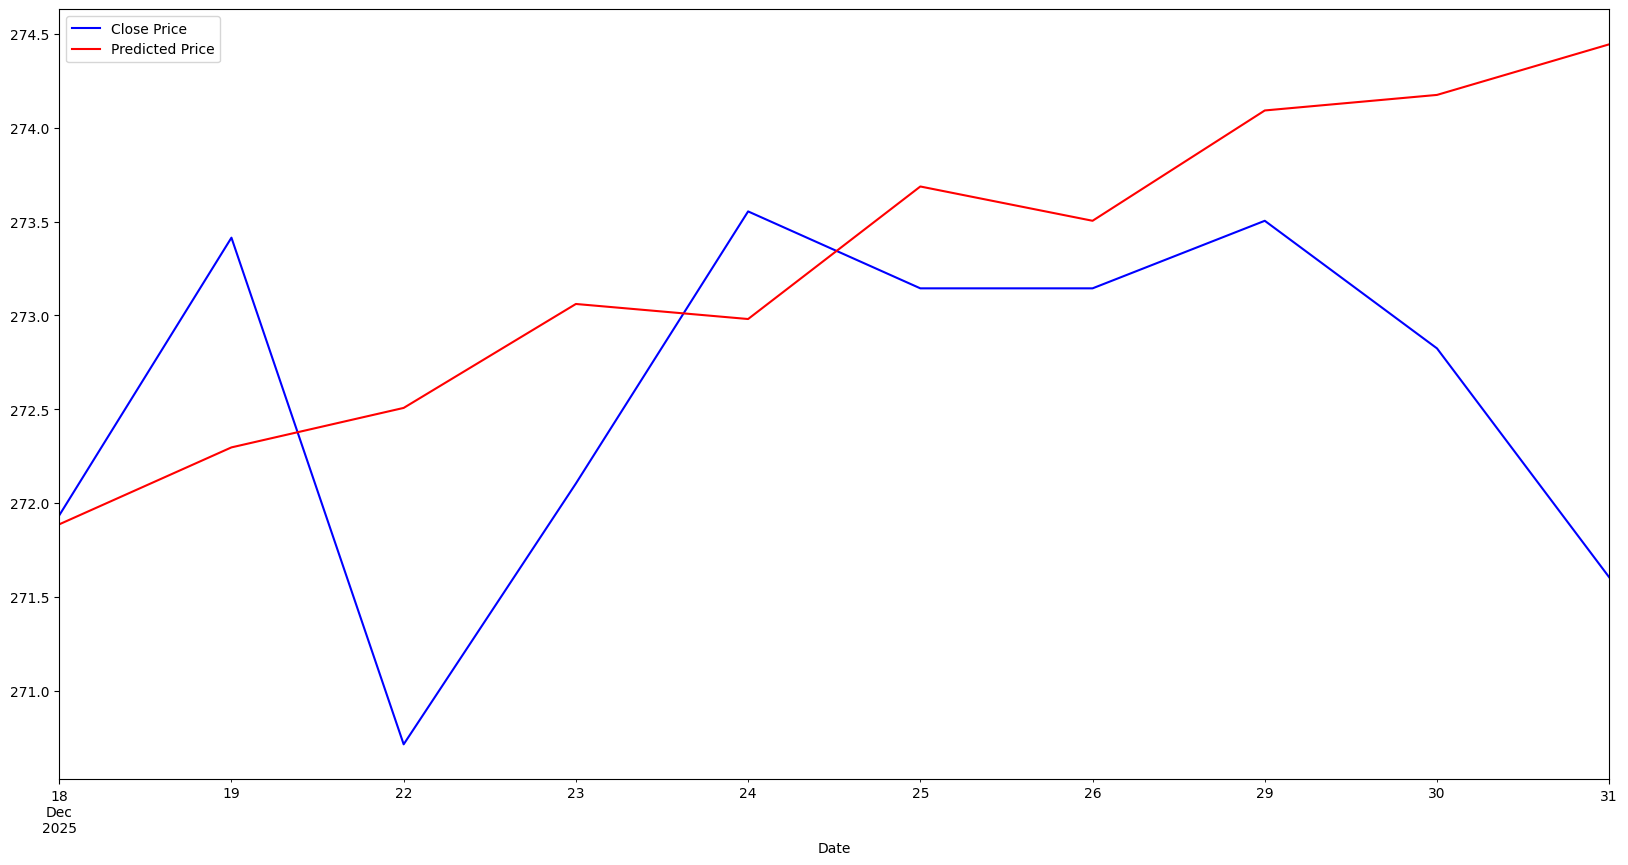

In [ ]:
df_test_10['AAPL_Close'].plot(color='blue',label='Close Price',figsize=(20,10))
y_forecast_prices.plot(color='red',label='Predicted Price',figsize=(20,10))
plt.legend()
plt.show()

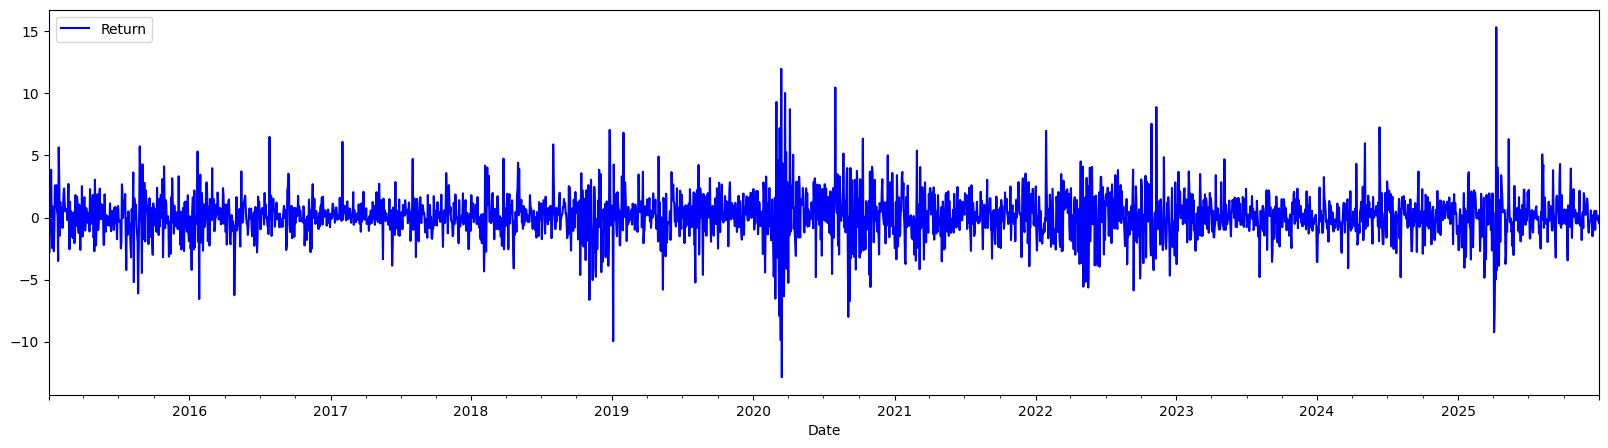

In [ ]:
df['AAPL_Close_Return'].plot(figsize=(20,5),label='Return',color='blue')
plt.legend()
plt.show()

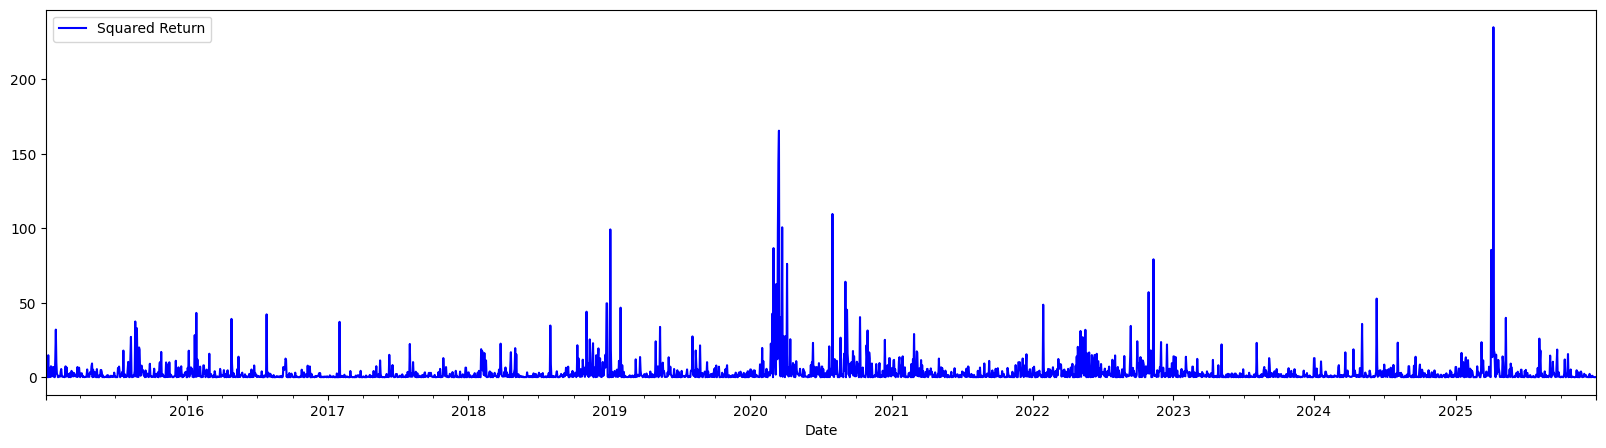

In [ ]:
df['AAPL_Close_Return_Squared'].plot(figsize=(20,5),label='Squared Return',color='blue')
plt.legend()
plt.show()

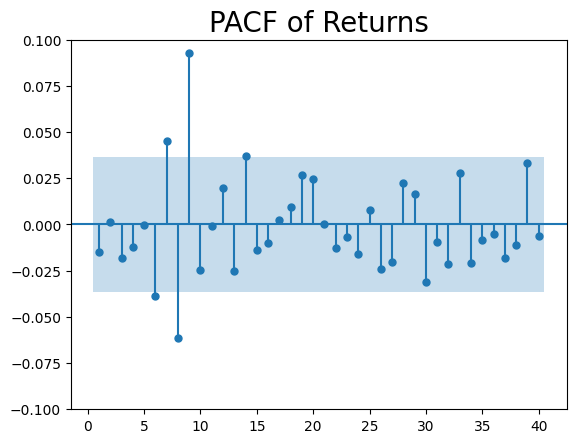

In [ ]:
plot_pacf(df['AAPL_Close_Return'][1:],alpha=0.05,lags=40,zero=False,method=('ols'))
plt.title("PACF of Returns", size = 20)
plt.ylim((-0.1,0.1))
plt.show()

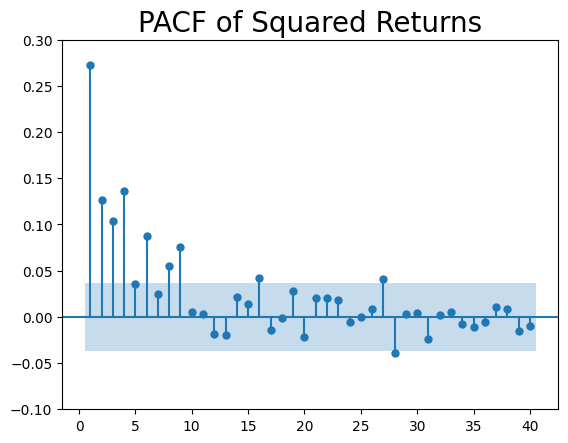

In [ ]:
plot_pacf(df['AAPL_Close_Return_Squared'][1:],alpha=0.05,lags=40,zero=False,method=('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.ylim((-0.1,0.3))
plt.show()

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      AAPL_Close_Return   No. Observations:                 2859
Model:                 ARIMA(2, 0, 6)   Log Likelihood               -5748.970
Date:                Sat, 14 Feb 2026   AIC                          11517.940
Time:                        11:38:16   BIC                          11577.523
Sample:                    01-02-2015   HQIC                         11539.425
                         - 12-17-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0937      0.034      2.744      0.006       0.027       0.161
ar.L1         -1.5525      0.052    -29.757      0.000      -1.655      -1.450
ar.L2         -0.7761      0.050    -15.558      0.000      -0.874      -0.678
ma.L1          1.5528      0.054     28.960      0.000       1.448       1.658
ma.L2          0.7683      0.055     13.911      0.000       0.660       0.877
ma.L3         -0.0302      0.027     -1.133      0.257      -0.082       0.022
ma.L4         -0.0412      0.025     -1.655      0.098      -0.090       0.008
ma.L5         -0.0347      0.026     -1.348      0.178      -0.085       0.016
ma.L6         -0.0526      0.017     -3.116      0.002      -0.086      -0.020
sigma2         3.2666      0.052     63.175      0.000       3.165       3.368
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3638.04
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_residuals=best_model.resid[1:]
arima_residuals

,0
Date,
2015-01-05,-2.948506
2015-01-06,-0.119236
2015-01-07,1.250810
2015-01-08,3.676991
2015-01-09,0.019823
...,...
2025-12-11,-0.428056
2025-12-12,0.009171
2025-12-15,-1.617341


In [ ]:
arch_1=arch_model(arima_residuals,
                mean='Zero',
                vol='ARCH',
                p=1
                )
result_arch_1=arch_1.fit()
result_arch_1.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: 1403572.3841583661
Iteration:      2,   Func. Count:      9,   Neg. LLF: 5852.991013504815
Iteration:      3,   Func. Count:     15,   Neg. LLF: 5623.100096659522
Iteration:      4,   Func. Count:     17,   Neg. LLF: 5623.100096659464
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5623.100096659522
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5623.10
Distribution:                  Normal   AIC:                           11250.2
Method:            Maximum Likelihood   BIC:                           11262.1
                                        No. Observations:                 2858
Date:                Sat, Feb 14 2026   Df Residuals:                     2858
Time:                        11:38:28   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.3876      0.152     15.727  9.872e-56 [  2.090,  2.685]
alpha[1]       0.2724  5.183e-02      5.255  1.483e-07 [  0.171,  0.374]
========================================================================

Covariance estimator: robust
"""

In [ ]:
arch_9=arch_model(arima_residuals,
                mean='Zero',
                vol='ARCH',
                p=9
                )
result_arch_9=arch_9.fit()
result_arch_9.summary()

Iteration:      1,   Func. Count:     12,   Neg. LLF: 5767.998780148499
Iteration:      2,   Func. Count:     25,   Neg. LLF: 16487.8373557457
Iteration:      3,   Func. Count:     37,   Neg. LLF: 14823.779861502455
Iteration:      4,   Func. Count:     50,   Neg. LLF: 5858.740497299766
Iteration:      5,   Func. Count:     62,   Neg. LLF: 17400.10154505716
Iteration:      6,   Func. Count:     75,   Neg. LLF: 16214.47625411446
Iteration:      7,   Func. Count:     88,   Neg. LLF: 5604.370672075092
Iteration:      8,   Func. Count:    101,   Neg. LLF: 5540.091019925274
Iteration:      9,   Func. Count:    114,   Neg. LLF: 5549.802050571401
Iteration:     10,   Func. Count:    126,   Neg. LLF: 5497.9527114736575
Iteration:     11,   Func. Count:    138,   Neg. LLF: 5512.183176295299
Iteration:     12,   Func. Count:    151,   Neg. LLF: 5535.649250893468
Iteration:     13,   Func. Count:    164,   Neg. LLF: 5479.59609988556
Iteration:     14,   Func. Count:    176,   Neg. LLF: 5520.84249

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5475.61
Distribution:                  Normal   AIC:                           10971.2
Method:            Maximum Likelihood   BIC:                           11030.8
                                        No. Observations:                 2858
Date:                Sat, Feb 14 2026   Df Residuals:                     2858
Time:                        11:38:37   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1372      0.139      8.168  3.132e-16      [  0.864,  1.410]
alpha[1]       0.1545  3.500e-02      4.414  1.015e-05    [8.589e-02,  0.223]
alpha[2]       0.0638  2.895e-02      2.202  2.764e-02    [7.020e-03,  0.121]
alpha[3]       0.1033  3.579e-02      2.886  3.900e-03    [3.315e-02,  0.173]
alpha[4]       0.0652  3.849e-02      1.695  9.002e-02   [-1.019e-02,  0.141]
alpha[5]       0.0461  2.949e-02      1.563      0.118   [-1.171e-02,  0.104]
alpha[6]       0.0846  3.363e-02      2.517  1.184e-02    [1.873e-02,  0.151]
alpha[7]       0.0348  2.516e-02      1.381      0.167 [-1.456e-02,8.408e-02]
alpha[8]       0.0656  3.134e-02      2.093  3.631e-02    [4.183e-03,  0.127]
alpha[9]       0.0385  2.688e-02      1.431      0.152 [-1.422e-02,9.114e-02]
=============================================================================

Covariance estimator: robust
"""

In [ ]:

def LLR_test_ARCH(mod_1, mod_2, DF=1):
    L1 = mod_1.loglikelihood
    L2 = mod_2.loglikelihood
    LR = (2 * (L2 - L1))
    p = chi2.sf(LR, DF).round(3)
    return p



In [ ]:
print('p_value= ',LLR_test_ARCH(result_arch_1,result_arch_9,DF=8))

p_value=  0.0


In [ ]:
forecast_vol =np.sqrt(result_arch_9.forecast(horizon=len(df_test_10['AAPL_Close_Return'])).variance.iloc[-1])
type(forecast_vol)

pandas.core.series.Series

In [ ]:
# predicted_prices =best_model.forecast(steps=len(df_test['AAPL_Close_Return']))
predicted_returns =best_model.forecast(steps=len(df_test_10['AAPL_Close_Return']))
type(predicted_returns)

pandas.core.series.Series

In [ ]:
len(df_train_10)

2859

In [ ]:
len(df_test_10.index)

10

In [ ]:
# upper_prices = predicted_prices.values + 1.96 * forecast_vol.values
# upper_prices=pd.Series(upper_prices, index=predicted_prices.index)
# lower_prices = predicted_prices.values - 1.96 * forecast_vol.values
# lower_prices = pd.Series(lower_prices, index=predicted_prices.index)
# ------------
# if train arima in returns
last_price = df['AAPL_Close'].iloc[len(df_train_10)]
predicted_prices = [last_price]

for r in predicted_returns:
    next_price = predicted_prices[-1] * (1 + r/100)
    predicted_prices.append(next_price)

predicted_prices = predicted_prices[1:]
predicted_prices=pd.Series(predicted_prices,
                           index=df_test_10.index)
# predicted_prices
upper_prices = predicted_prices * (1 + 1.96 * forecast_vol.values/100)
upper_price = pd.Series(
    upper_prices,
    index=df_test_10.index
)
lower_prices = predicted_prices * (1 - 1.96 * forecast_vol.values/100)
lower_prices = pd.Series(
    lower_prices,
    index=df_test_10.index
)



In [ ]:
predicted_prices

,0
Date,
2025-12-18,272.237979
2025-12-19,272.648185
2025-12-22,272.858649
2025-12-23,273.412764
2025-12-24,273.332548
2025-12-25,274.039075
2025-12-26,273.856275
2025-12-29,274.444374
2025-12-30,274.527255


In [ ]:
lower_prices

,0
Date,
2025-12-18,265.362304
2025-12-19,265.717229
2025-12-22,265.730088
2025-12-23,265.809324
2025-12-24,265.756790
2025-12-25,266.033235
2025-12-26,265.726008
2025-12-29,266.224272
2025-12-30,266.083231


In [ ]:
upper_prices

,0
Date,
2025-12-18,279.113655
2025-12-19,279.579142
2025-12-22,279.987210
2025-12-23,281.016204
2025-12-24,280.908306
2025-12-25,282.044915
2025-12-26,281.986542
2025-12-29,282.664476
2025-12-30,282.971279


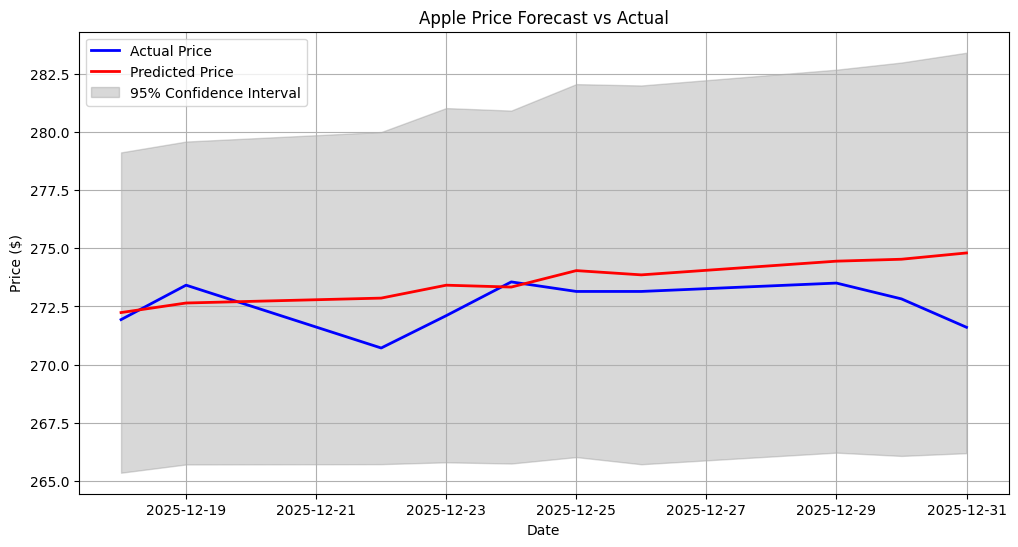

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual prices
plt.plot(df_test_10['AAPL_Close'], label='Actual Price', color='blue', linewidth=2)


# Plot predicted prices
plt.plot(predicted_prices, label='Predicted Price', color='red', linewidth=2)

# Plot confidence interval as shaded area
plt.fill_between(
    df_test_10.index,
    lower_prices,
    upper_prices,
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Apple Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
arima_residuals

,None
Date,
2015-01-05,-2.948506
2015-01-06,-0.119236
2015-01-07,1.250810
2015-01-08,3.676991
2015-01-09,0.019823
...,...
2025-12-11,-0.428056
2025-12-12,0.009171
2025-12-15,-1.617341


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5475.40
Distribution:                  Normal   AIC:                           10956.8
Method:            Maximum Likelihood   BIC:                           10974.7
                                        No. Observations:                 2858
Date:                Sat, Feb 14 2026   Df Residuals:                     2858
Time:                        11:51:20   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1502  5.063e-02      2.967  3.008e-03 [5.098e-02,  0.249]
alpha[1]       0.1059  2.296e-02      4.611  3.998e-06 [6.089e-02,  0.151]
beta[1]        0.8469  3.368e-02     25.148 1.495e-139   [  0.781,  0.913]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
import pandas as pd

p_range = range(1, 4)
q_range = range(1, 4)
garch_results = []

for p in p_range:
    for q in q_range:
        try:
            model = arch_model(arima_residuals, mean='Zero', vol='GARCH', p=p, q=q)
            res = model.fit(disp='off')

            # Calculate persistence
            persistence = sum(res.params[1:]) # Sum of alphas and betas

            garch_results.append({
                'p': p,
                'q': q,
                'BIC': res.bic,
                'AIC': res.aic,
                'LogLikelihood': res.loglikelihood,
                'Stable': persistence < 1
            })
        except:
            continue

# Convert to DataFrame and find the best
df_garch_results = pd.DataFrame(garch_results)
best_model = df_garch_results[df_garch_results['Stable'] == True].sort_values(by='BIC').iloc[0]

print("Best Stable Model based on BIC:")
print(best_model)

Best Stable Model based on BIC:
p                           1
q                           1
BIC              10974.677644
AIC              10956.804012
LogLikelihood    -5475.402006
Stable                   True
Name: 0, dtype: object


In [ ]:
df_garch_results

,p,q,BIC,AIC,LogLikelihood,Stable
0,1,1,10974.677644,10956.804012,-5475.402006,True
1,1,2,10977.388208,10953.556698,-5472.778349,True
2,1,3,10984.933804,10955.144417,-5472.572209,True
3,2,1,10982.635521,10958.804012,-5475.402006,True
4,2,2,10985.346085,10955.556698,-5472.778349,True
5,2,3,10992.348797,10956.601533,-5472.300766,True
6,3,1,10990.593398,10960.804011,-5475.402006,True
7,3,2,10993.303962,10957.556698,-5472.778349,True
8,3,3,11000.212299,10958.507158,-5472.253579,True


In [ ]:
Garch_1=arch_model(arima_residuals,
                mean='Zero',
                vol='GARCH',
                p=1,
                q=1,
                dist='normal'
                )
result_garch_1=Garch_1.fit(disp='off')
result_garch_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5475.40
Distribution:                  Normal   AIC:                           10956.8
Method:            Maximum Likelihood   BIC:                           10974.7
                                        No. Observations:                 2858
Date:                Sat, Feb 14 2026   Df Residuals:                     2858
Time:                        11:59:50   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1502  5.063e-02      2.967  3.008e-03 [5.098e-02,  0.249]
alpha[1]       0.1059  2.296e-02      4.611  3.998e-06 [6.089e-02,  0.151]
beta[1]        0.8469  3.368e-02     25.148 1.495e-139   [  0.781,  0.913]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
forecast_vol_garch =np.sqrt(result_garch_1.forecast(horizon=len(df_test_10['AAPL_Close_Return'])).variance.iloc[-1])
forecast_vol_garch

,2025-12-17
h.01,1.233419
h.02,1.264799
h.03,1.293989
h.04,1.321202
h.05,1.346618
h.06,1.370396
h.07,1.392674
h.08,1.413573
h.09,1.433202
h.10,1.451658


In [ ]:
# upper_prices = predicted_prices.values + 1.96 * forecast_vol_garch.values
# upper_prices=pd.Series(upper_prices, index=predicted_prices.index)
# lower_prices = predicted_prices.values - 1.96 * forecast_vol_garch.values
# lower_prices = pd.Series(lower_prices, index=predicted_prices.index)
forecast_vol_garch=pd.Series(forecast_vol_garch.values, index=predicted_prices.index)
upper_prices = predicted_prices.values + (1+forecast_vol_garch/100)
upper_prices=pd.Series(upper_prices, index=predicted_prices.index)
lower_prices = predicted_prices.values - (1+forecast_vol_garch/100)
lower_prices = pd.Series(lower_prices, index=predicted_prices.index)

In [ ]:
# forecast_vol_garch
# predicted_prices

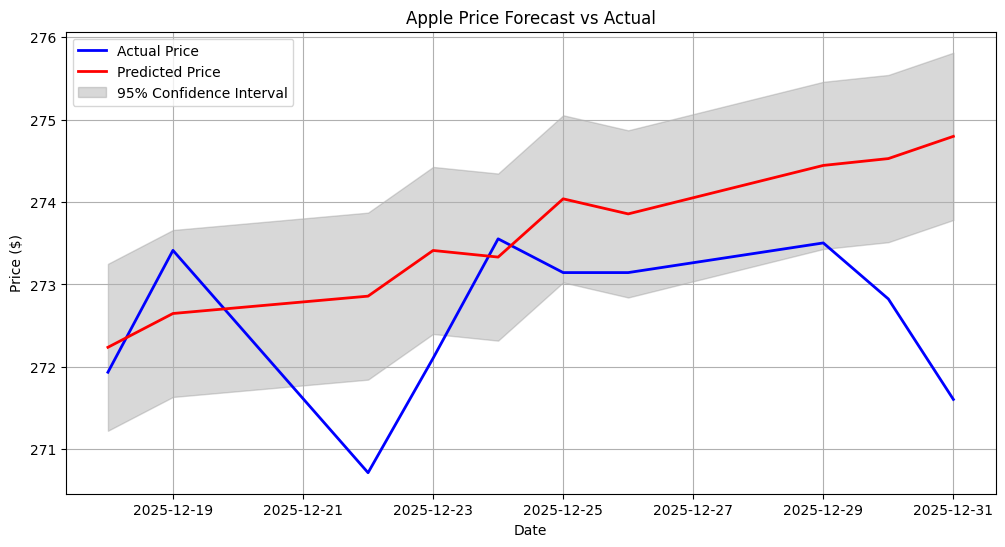

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual prices
plt.plot(df_test_10['AAPL_Close'], label='Actual Price', color='blue', linewidth=2)


# Plot predicted prices
plt.plot(predicted_prices, label='Predicted Price', color='red', linewidth=2)

# Plot confidence interval as shaded area
plt.fill_between(
    predicted_prices.index,
    lower_prices,
    upper_prices,
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Apple Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.to_csv('Apple_Stock_Price.csv')

**LSTM**

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train=scaler.fit_transform(df_train[['AAPL_Close']])
scaled_test=scaler.transform(df_test[['AAPL_Close']])


In [ ]:
def create_sequences(data, window=90):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size=90
x_train,y_train=create_sequences(scaled_train,window_size)
x_test,y_test=create_sequences(scaled_test,window_size)

In [ ]:
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test=x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
model=Sequential([
    Bidirectional(LSTM(50,return_sequences=True,input_shape=(window_size,1))),
    Dropout(0.2),
    Bidirectional(LSTM(50,return_sequences=False,input_shape=(window_size,1))),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history=model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 0.0285 - val_loss: 0.0063
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 0.0013 - val_loss: 0.0069
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/s

In [ ]:
predicted_scaled=model.predict(x_test)
predicted_scaled

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


array([[0.9338041 ],
       [0.9332946 ],
       [0.9315437 ],
       [0.9318831 ],
       [0.9310592 ],
       [0.92978555],
       [0.92752844],
       [0.9203954 ],
       [0.9084975 ],
       [0.89711845],
       [0.8875998 ],
       [0.8821946 ],
       [0.88085276],
       [0.8812329 ],
       [0.8798856 ],
       [0.88131005],
       [0.88245517],
       [0.8849549 ],
       [0.8899848 ],
       [0.8974505 ],
       [0.8953649 ],
       [0.8940524 ],
       [0.89092994],
       [0.8867303 ],
       [0.8872426 ],
       [0.8858661 ],
       [0.8831301 ],
       [0.8808387 ],
       [0.8776207 ],
       [0.8759377 ],
       [0.8737605 ],
       [0.8729665 ],
       [0.8712271 ],
       [0.8712633 ],
       [0.8693109 ],
       [0.876115  ],
       [0.8841462 ],
       [0.88669175],
       [0.88458395],
       [0.8805561 ],
       [0.8755697 ],
       [0.8687512 ],
       [0.86385053],
       [0.8611316 ],
       [0.86170727],
       [0.86371684],
       [0.86512935],
       [0.871

In [ ]:
predicted_prices=scaler.inverse_transform(predicted_scaled)
actual_prices=scaler.inverse_transform(y_test.reshape(-1,1))

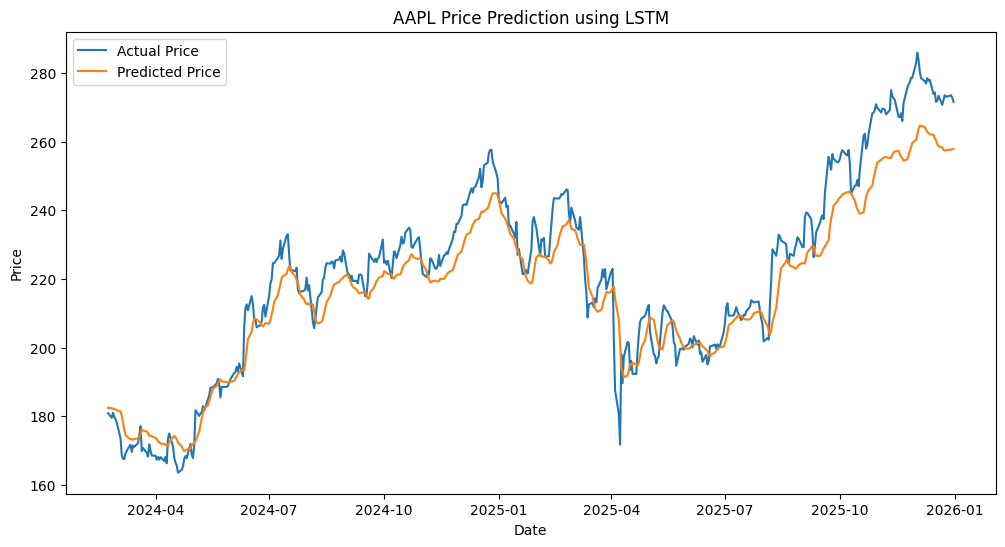

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_test.index[window_size:], actual_prices, label='Actual Price')
plt.plot(df_test.index[window_size:], predicted_prices, label='Predicted Price')
plt.title('AAPL Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_test.index[window_size:], actual_prices, label='Actual Price')
plt.plot(df_test.index[window_size:], predicted_prices, label='Predicted Price')
plt.title('AAPL Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
predicted_prices.shape,actual_prices.shape

((484, 1), (484, 1))

In [ ]:
diff=actual_prices-predicted_prices

In [ ]:
np.concat((predicted_prices,actual_prices,diff),1)[:10]

array([[182.44, 180.87,  -1.57],
       [182.35, 179.53,  -2.82],
       [182.05, 180.98,  -1.06],
       [182.11, 179.78,  -2.32],
       [181.96, 179.12,  -2.84],
       [181.74, 178.04,  -3.7 ],
       [181.35, 173.52,  -7.83],
       [180.11, 168.59, -11.53],
       [178.05, 167.59, -10.46],
       [176.08, 167.48,  -8.6 ]])

In [ ]:
RMSE_LSTM=np.sqrt(mean_squared_error(actual_prices[-365:],predicted_prices[-365:]))
print('RMSE For LSTM : ',RMSE_LSTM)

RMSE For LSTM :  9.76369615522993


In [ ]:
data=df['AAPL_Close']
data

,AAPL_Close
Date,
2015-01-02,24.214893
2015-01-05,23.532719
2015-01-06,23.534939
2015-01-07,23.864952
2015-01-08,24.781887
...,...
2025-12-25,273.144409
2025-12-26,273.144409
2025-12-29,273.504089


# Time-Series Cross-Validation(Walk-Forward Validation)


## 1- Expanding Window:
- Fold 1: Train on Year 1 $\rightarrow$ Test on Year 2.
- Fold 2: Train on Year 1-2 $\rightarrow$ Test on Year 3.
- Fold 3: Train on Year 1-3 $\rightarrow$ Test on Year 4.

In [ ]:
tscv=TimeSeriesSplit(n_splits=5)
for train_index,test_index in tscv.split(data):
  train,test=data[train_index],data[test_index]
  model= ARIMA(train,order=(1,1,1))
  model_fit=model.fit()
  predictions_Expanding_Window=model_fit.forecast(steps=len(test))
  rmse=np.sqrt(mean_squared_error(test,predictions_Expanding_Window))
  print(f"Expanding Window RMSE : {rmse:.2f}")

Expanding Window RMSE : 13.20
Expanding Window RMSE : 13.54
Expanding Window RMSE : 51.83
Expanding Window RMSE : 20.71
Expanding Window RMSE : 52.05


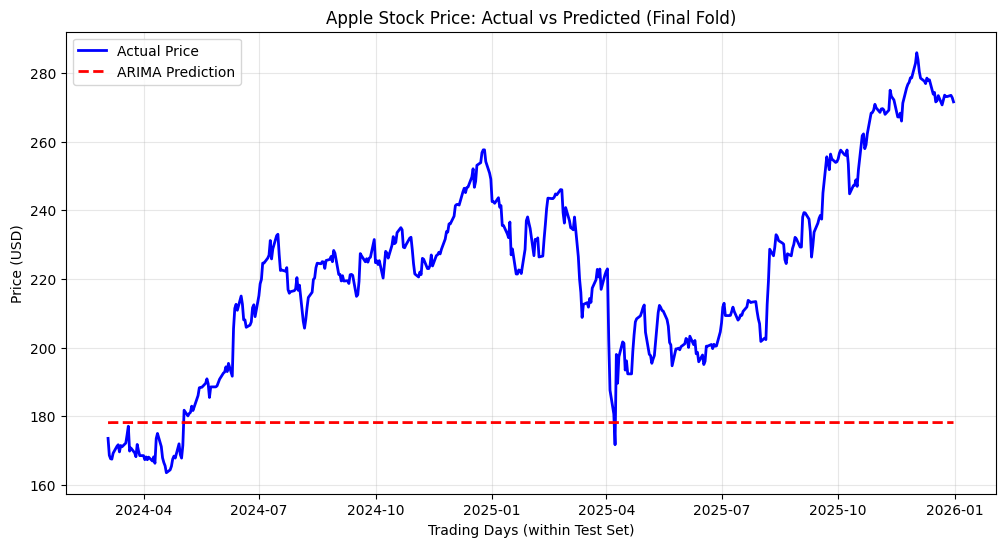

In [ ]:
import matplotlib.pyplot as plt

# Using the data from your LAST fold in the loop
plt.figure(figsize=(12, 6))

# 1. Plot the actual prices (Testing set)
plt.plot(test, label='Actual Price', color='blue', linewidth=2)

# 2. Plot the ARIMA predictions
plt.plot(predictions_Expanding_Window, label='ARIMA Prediction', color='red', linestyle='--', linewidth=2)

plt.title('Apple Stock Price: Actual vs Predicted (Final Fold)')
plt.xlabel('Trading Days (within Test Set)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
RMSE_Expanding_window=np.sqrt(mean_squared_error(predictions_Expanding_Window[-365:],test[-365:]))
print('RMSE Expanding window : ',RMSE_Expanding_window)

RMSE Expanding window :  57.84776682266488


In [ ]:
len(predictions_Expanding_Window)

478

## 2- Rolling (Sliding) Window
- Fold 1: Train on Year 1 $\rightarrow$ Test on Year 2.
- Fold 2: Train on Year 2 $\rightarrow$ Test on Year 3.
- Fold 3: Train on Year 3 $\rightarrow$ Test on Year 4.

In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

window_size = 750  # 3 years training
test_size = 250    # 1 year testing
history = list(data[:window_size])
test_data = data[window_size:]

Rolling_Predictions = []
actuals = []

for i in range(0, len(test_data), test_size):
    # 1. Define the current test batch
    batch_actuals = test_data[i : i + test_size]

    # 2. Check if we have enough actual data left to compare
    # This prevents the loop from breaking at the end of 2025
    current_steps = len(batch_actuals)
    if current_steps == 0:
        break

    # 3. Fit Model
    model = ARIMA(history, order=(1, 1, 1)) # Optimized from (5,1,0) to prevent LinAlgError
    model_fit = model.fit()

    # 4. Forecast only the number of days available in this batch
    yhat = model_fit.forecast(steps=current_steps)

    Rolling_Predictions.extend(yhat)
    actuals.extend(batch_actuals)

    # 5. SLIDING WINDOW UPDATE:
    # Add the new batch to history and remove the oldest batch
    history.extend(batch_actuals)
    history = history[current_steps:]

print(f"Total Predicted Points: {len(predictions)}")
print(f"Total Actual Points: {len(actuals)}")

Total Predicted Points: 2119
Total Actual Points: 2119


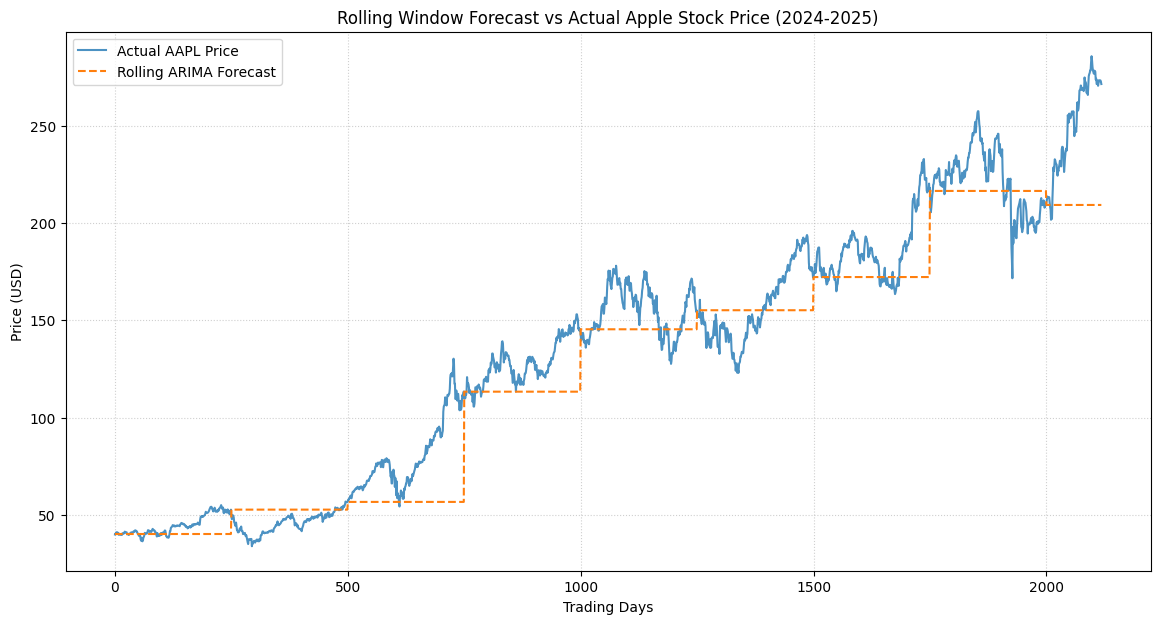

In [ ]:
import matplotlib.pyplot as plt

# Assuming you ran the Rolling Window loop from the previous step
# and stored your results in 'predictions' and 'actuals'

plt.figure(figsize=(14, 7))

# 1. Plot the Actual Prices
plt.plot(actuals, label='Actual AAPL Price', color='#1f77b4', alpha=0.8)

# 2. Plot the Rolling Predictions
plt.plot(Rolling_Predictions, label='Rolling ARIMA Forecast', color='#ff7f0e', linestyle='--')

plt.title('Rolling Window Forecast vs Actual Apple Stock Price (2024-2025)')
plt.xlabel('Trading Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

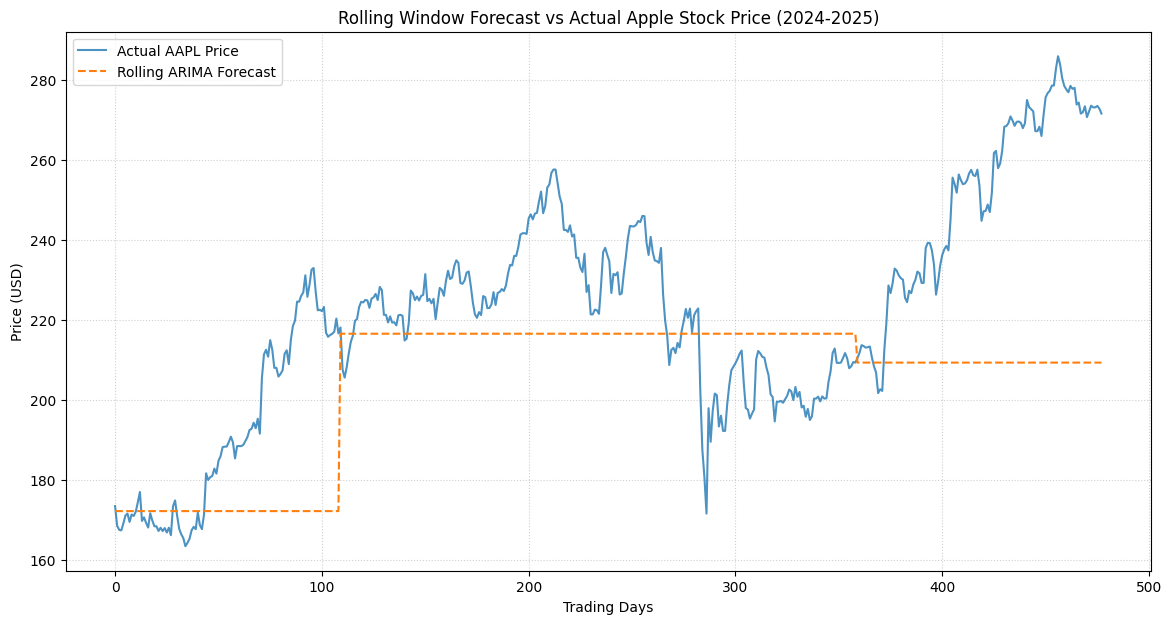

In [ ]:
import matplotlib.pyplot as plt

# Assuming you ran the Rolling Window loop from the previous step
# and stored your results in 'predictions' and 'actuals'

plt.figure(figsize=(14, 7))

# 1. Plot the Actual Prices
plt.plot(actuals[-478:], label='Actual AAPL Price', color='#1f77b4', alpha=0.8)

# 2. Plot the Rolling Predictions
plt.plot(Rolling_Predictions[-478:], label='Rolling ARIMA Forecast', color='#ff7f0e', linestyle='--')

plt.title('Rolling Window Forecast vs Actual Apple Stock Price (2024-2025)')
plt.xlabel('Trading Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [ ]:
RMSE_Rolling_window=np.sqrt(mean_squared_error(actuals[-365:],Rolling_Predictions[-365:]))

print('RMSE Rolling window : ',RMSE_Rolling_window)

RMSE Rolling window :  30.45305142725567


In [ ]:
len(df_test)

574

# Prophet Model:

In [ ]:
df_prophet=df['AAPL_Close'].reset_index()
df_prophet.columns=['ds','y']
df_prophet

,ds,y
0,2015-01-02,24.214893
1,2015-01-05,23.532719
2,2015-01-06,23.534939
3,2015-01-07,23.864952
4,2015-01-08,24.781887
...,...,...
2864,2025-12-25,273.144409
2865,2025-12-26,273.144409
2866,2025-12-29,273.504089
2867,2025-12-30,272.824707


In [ ]:
train_prophet=df_prophet[df_prophet['ds']<'2024-03-04']
test_prophet=df_prophet[df_prophet['ds']>='2024-03-04']

In [ ]:
prophet_model=Prophet()
prophet_model.fit(train_prophet)
future=prophet_model.make_future_dataframe(periods=len(test_prophet),freq="B")
prophet_forecasts=prophet_model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_forecasts

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,27.764593,18.359418,35.943682,27.764593,27.764593,-0.839575,-0.839575,-0.839575,0.750382,0.750382,0.750382,-1.589957,-1.589957,-1.589957,0.0,0.0,0.0,26.925018
1,2015-01-05,27.732020,17.852439,36.068978,27.732020,27.732020,-1.342989,-1.342989,-1.342989,0.719199,0.719199,0.719199,-2.062188,-2.062188,-2.062188,0.0,0.0,0.0,26.389031
2,2015-01-06,27.721163,17.497455,35.673639,27.721163,27.721163,-1.385826,-1.385826,-1.385826,0.810524,0.810524,0.810524,-2.196349,-2.196349,-2.196349,0.0,0.0,0.0,26.335337
3,2015-01-07,27.710305,17.427265,36.001011,27.710305,27.710305,-1.470418,-1.470418,-1.470418,0.844584,0.844584,0.844584,-2.315002,-2.315002,-2.315002,0.0,0.0,0.0,26.239887
4,2015-01-08,27.699447,16.210932,34.592585,27.699447,27.699447,-1.666360,-1.666360,-1.666360,0.749698,0.749698,0.749698,-2.416057,-2.416057,-2.416057,0.0,0.0,0.0,26.033088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,2025-12-25,228.588738,173.928929,277.208690,173.550698,276.081128,0.467164,0.467164,0.467164,0.749698,0.749698,0.749698,-0.282534,-0.282534,-0.282534,0.0,0.0,0.0,229.055902
2865,2025-12-26,228.653751,174.108679,277.215302,173.350226,276.399098,0.316597,0.316597,0.316597,0.750382,0.750382,0.750382,-0.433785,-0.433785,-0.433785,0.0,0.0,0.0,228.970348
2866,2025-12-29,228.848791,172.980162,277.081599,173.345301,276.740470,-0.214422,-0.214422,-0.214422,0.719199,0.719199,0.719199,-0.933622,-0.933622,-0.933622,0.0,0.0,0.0,228.634369
2867,2025-12-30,228.913805,172.922569,277.486197,173.303900,276.943754,-0.298784,-0.298784,-0.298784,0.810524,0.810524,0.810524,-1.109307,-1.109307,-1.109307,0.0,0.0,0.0,228.615021


In [ ]:
prophet_predictions=prophet_forecasts.iloc[-len(test_prophet):]['yhat'].values
prophet_actual=test_prophet['y'].values


In [ ]:
len(prophet_actual)

478

In [ ]:
prophet_rmse=np.sqrt(mean_squared_error(prophet_actual[-365:],prophet_predictions[-365:]))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

Prophet RMSE: 28.08


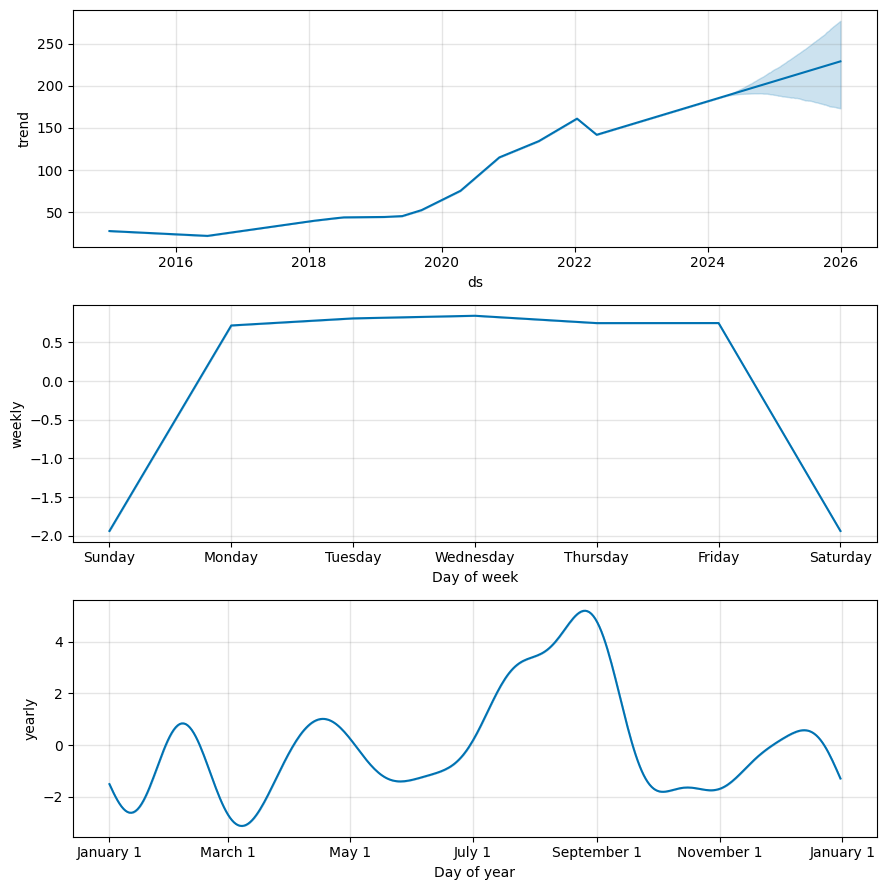

In [ ]:
prophet_model.plot_components(prophet_forecasts)
plt.show()

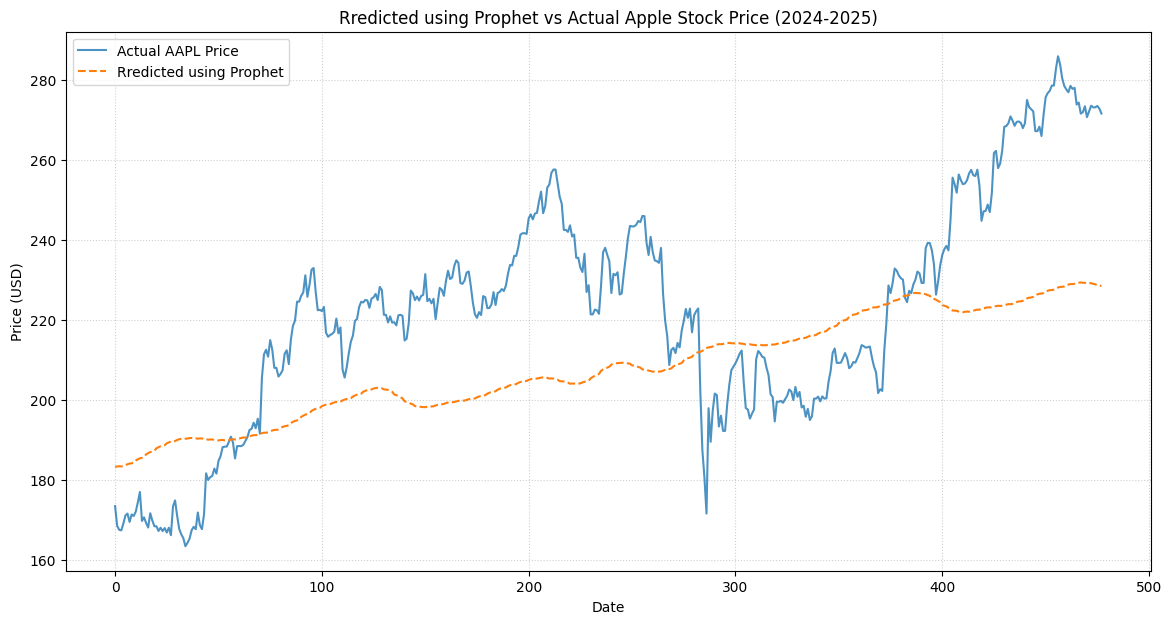

In [ ]:
import matplotlib.pyplot as plt

# Assuming you ran the Rolling Window loop from the previous step
# and stored your results in 'predictions' and 'actuals'

plt.figure(figsize=(14, 7))

# 1. Plot the Actual Prices
plt.plot(prophet_actual, label='Actual AAPL Price', color='#1f77b4', alpha=0.8)

# 2. Plot the Rolling Predictions
plt.plot(prophet_predictions, label='Rredicted using Prophet', color='#ff7f0e', linestyle='--')

plt.title('Rredicted using Prophet vs Actual Apple Stock Price (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

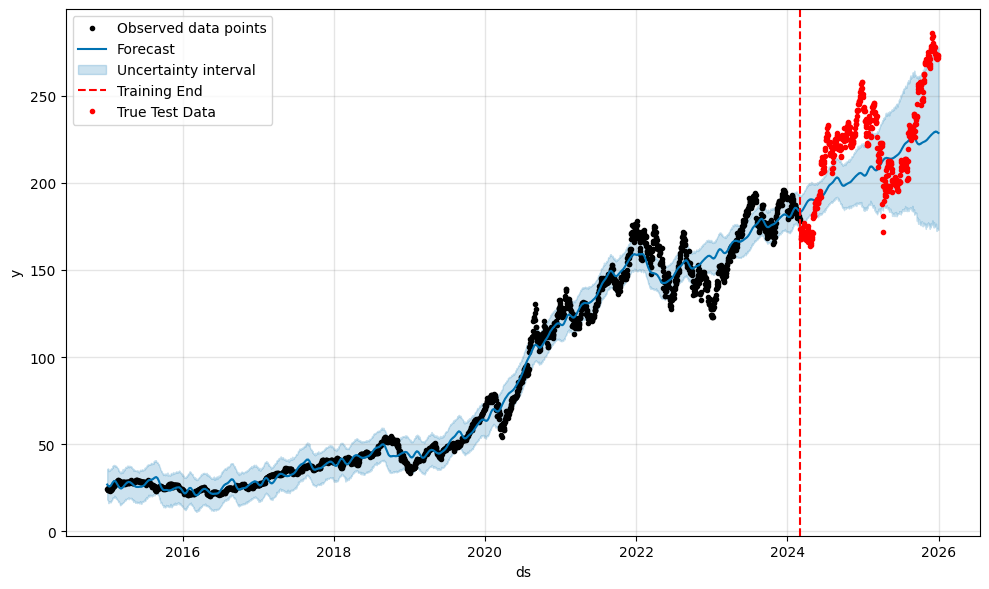

In [ ]:
forecast_plot =prophet_model.plot(prophet_forecasts)
axes = forecast_plot.gca()
last_training_date = prophet_forecasts['ds'].iloc[-len(test_prophet)]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')
plt.plot(test_prophet['ds'], test_prophet['y'],'ro', markersize=3, label='True Test Data')
plt.legend()

In [ ]:

RMSE_Prophet=np.sqrt(mean_squared_error(prophet_actual,prophet_predictions))
print('RMSE Prophet : ',RMSE_Prophet)

RMSE Prophet :  26.077024624742947


In [ ]:
test_prophet

,ds,y
2391,2024-03-04,173.520798
2392,2024-03-05,168.585724
2393,2024-03-06,167.594757
2394,2024-03-07,167.475830
2395,2024-03-08,169.190201
...,...,...
2864,2025-12-25,273.144409
2865,2025-12-26,273.144409
2866,2025-12-29,273.504089
2867,2025-12-30,272.824707


# XGBoost

In [ ]:
def create_features(df):
    df = df.copy()
    # 1. أعمدة تعتمد على التاريخ
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    for i in range(1,4):
      df[f'lag_{i}']=df['AAPL_Close'].shift(1)
    df['ma_7']=df['AAPL_Close'].shift(1).rolling(window=7).mean()
    return df
features_df=create_features(df)
features_df=features_df.dropna()

In [ ]:
features_df

Ticker            AAPL                                                   \
Price             Open        High         Low       Close       Volume   
Date                                                                      
2015-01-13   24.680010   24.983444   24.121870   24.412014  268367600.0   
2015-01-14   24.150660   24.471812   24.031058   24.318989  195826400.0   
2015-01-15   24.363291   24.376579   23.623533   23.658970  240056000.0   
2015-01-16   23.705478   23.827295   23.300161   23.475134  314053200.0   
2015-01-19   23.884885   24.135163   23.588096   24.079792  199599600.0   
...                ...         ...         ...         ...          ...   
2025-12-25  273.903708  275.112569  272.604905  273.144409   21521800.0   
2025-12-26  273.903708  275.112569  272.604905  273.144409   21521800.0   
2025-12-29  272.435082  274.103504  272.095404  273.504089   23715200.0   
2025-12-30  272.554970  273.823772  272.025467  272.824707   22139600.0   
2025-12-31  272.804725  273.424141  271.495952  271.605835   27293600.0   

Ticker      AAPL_Close AAPL_Close_Return AAPL_Close_Return_Squared dayofweek  \
Price                                                                          
Date                                                                           
2015-01-13   24.412014          0.887896                  0.788359         1   
2015-01-14   24.318989         -0.381063                  0.145209         2   
2015-01-15   23.658970         -2.714006                  7.365831         3   
2015-01-16   23.475134         -0.777024                  0.603767         4   
2015-01-19   24.079792          2.575739                  6.634430         0   
...                ...               ...                       ...       ...   
2025-12-25  273.144409         -0.149735                  0.022421         3   
2025-12-26  273.144409         -0.149735                  0.022421         4   
2025-12-29  273.504089          0.131681                  0.017340         0   
2025-12-30  272.824707         -0.248399                  0.061702         1   
2025-12-31  271.605835         -0.446760                  0.199595         2   

Ticker     quarter month  year       lag_1       lag_2       lag_3        ma_7  
Price                                                                           
Date                                                                            
2015-01-13       1     1  2015   24.197168   24.197168   24.197168   24.133575  
2015-01-14       1     1  2015   24.412014   24.412014   24.412014   24.161735  
2015-01-15       1     1  2015   24.318989   24.318989   24.318989   24.274059  
2015-01-16       1     1  2015   23.658970   23.658970   23.658970   24.291778  
2015-01-19       1     1  2015   23.475134   23.475134   23.475134   24.236090  
...            ...   ...   ...         ...         ...         ...         ...  
2025-12-25       4    12  2025  273.554016  273.554016  273.554016  272.523564  
2025-12-26       4    12  2025  273.144409  273.144409  273.144409  272.350869  
2025-12-29       4    12  2025  273.144409  273.144409  273.144409  272.573517  
2025-12-30       4    12  2025  273.504089  273.504089  273.504089  272.797594  
2025-12-31       4    12  2025  272.824707  272.824707  272.824707  272.713383  

[2862 rows x 16 columns]

In [ ]:
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'lag_1', 'lag_2', 'lag_3', 'ma_7']
TARGET = 'AAPL_Close'
xgboost_train=features_df[features_df.index<'2025-01-01']
xgboost_test=features_df[features_df.index>='2025-01-01']
x_train_xgboost=xgboost_train[FEATURES]
y_train_xgboost=xgboost_train[TARGET]
x_test_xgboost=xgboost_test[FEATURES]
y_test_xgboost=xgboost_test[TARGET]

In [ ]:
def objective(trial):
      param = {
          'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
          'max_depth': trial.suggest_int('max_depth', 3, 9),
          'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
          'subsample': trial.suggest_float('subsample', 0.5, 0.9),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
          'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0), # Higher minimum
          'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),
          'early_stopping_rounds': 50
      }

      model = xgb.XGBRegressor(**param)

      model.fit(
          x_train_xgboost, y_train_xgboost,
          eval_set=[(x_test_xgboost, y_test_xgboost)],
          verbose=False
      )
      preds = model.predict(x_test_xgboost)
      rmse = np.sqrt(mean_squared_error(y_test_xgboost, preds))
      return rmse
study = optuna.create_study(direction='minimize') # هدفنا تقليل الـ RMSE
study.optimize(objective, n_trials=50) # سنجرب 50 توليفة مختلفة

print(f"Best RMSE found: {study.best_value:.2f}")
print(f"Best Parameters: {study.best_params}")


[I 2026-02-14 13:34:40,989] A new study created in memory with name: no-name-ce49dff9-f079-4fc0-9f26-bb9f6ce27e03
[I 2026-02-14 13:34:42,310] Trial 0 finished with value: 12.906096729380987 and parameters: {'n_estimators': 1796, 'max_depth': 6, 'learning_rate': 0.00989672001344672, 'subsample': 0.8810100661840201, 'colsample_bytree': 0.7721033225093727, 'reg_alpha': 33.42832821440763, 'reg_lambda': 36.897086830234215}. Best is trial 0 with value: 12.906096729380987.
[I 2026-02-14 13:34:44,623] Trial 1 finished with value: 12.252098066213577 and parameters: {'n_estimators': 841, 'max_depth': 7, 'learning_rate': 0.02344815142006547, 'subsample': 0.7676587971429907, 'colsample_bytree': 0.7057819323211786, 'reg_alpha': 13.544604202620668, 'reg_lambda': 45.9754898599917}. Best is trial 1 with value: 12.252098066213577.
[I 2026-02-14 13:34:45,256] Trial 2 finished with value: 11.472873463390746 and parameters: {'n_estimators': 998, 'max_depth': 3, 'learning_rate': 0.036543698616861034, 'subs

Best RMSE found: 10.61
Best Parameters: {'n_estimators': 887, 'max_depth': 8, 'learning_rate': 0.044436774312826034, 'subsample': 0.5333971278248413, 'colsample_bytree': 0.7938183312526179, 'reg_alpha': 1.2498795902364073, 'reg_lambda': 7.339548897567304}


In [ ]:
best_params = study.best_params
best_params['early_stopping_rounds'] = 50 # إضافة الـ stopping مرة أخرى

In [ ]:
best_params

{'n_estimators': 887,
 'max_depth': 8,
 'learning_rate': 0.044436774312826034,
 'subsample': 0.5333971278248413,
 'colsample_bytree': 0.7938183312526179,
 'reg_alpha': 1.2498795902364073,
 'reg_lambda': 7.339548897567304,
 'early_stopping_rounds': 50}

In [ ]:
final_model = xgb.XGBRegressor(**best_params)

final_model.fit(
    x_train_xgboost, y_train_xgboost,
    eval_set=[(x_train_xgboost, y_train_xgboost), (x_test_xgboost, y_test_xgboost)],
    verbose=100
)

[0]	validation_0-rmse:62.63608	validation_1-rmse:134.83609
[100]	validation_0-rmse:2.19550	validation_1-rmse:16.85654
[200]	validation_0-rmse:1.54427	validation_1-rmse:11.42507
[300]	validation_0-rmse:1.37532	validation_1-rmse:10.73868
[400]	validation_0-rmse:1.25507	validation_1-rmse:10.64156
[428]	validation_0-rmse:1.22609	validation_1-rmse:10.66080


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7938183312526179, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.044436774312826034,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=887, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# xgb_regressor=xgb.XGBRegressor(n_estimators=1000,
#                        early_stopping_rounds=50,
#                        learning_rate=0.01,
#                        max_depth=3,
#                        reg_alpha=0.1,
#                        reg_lambda=1,
#                        subsample=0.7,
#                        colsample_bytree=0.7)
# xgb_regressor.fit(x_train_xgboost, y_train_xgboost,
#         eval_set=[(x_train_xgboost, y_train_xgboost), (x_test_xgboost, y_test_xgboost)],
#         verbose=100)

In [ ]:
# 1. التنبؤ باستخدام الموديل النهائي
final_predictions = final_model.predict(x_test_xgboost)

final_preds_series = pd.Series(final_predictions, index=y_test_xgboost.index)

from sklearn.metrics import mean_squared_error, mean_absolute_error
RMSE_XGBOOST = np.sqrt(mean_squared_error(y_test_xgboost, final_predictions))
final_mae = mean_absolute_error(y_test_xgboost, final_predictions)

print(f"--- Final Model Performance ---")
print(f"Final RMSE: {final_rmse:.2f}")
print(f"Final MAE (Mean Absolute Error): {final_mae:.2f}")

--- Final Model Performance ---
Final RMSE: 10.61
Final MAE (Mean Absolute Error): 7.38


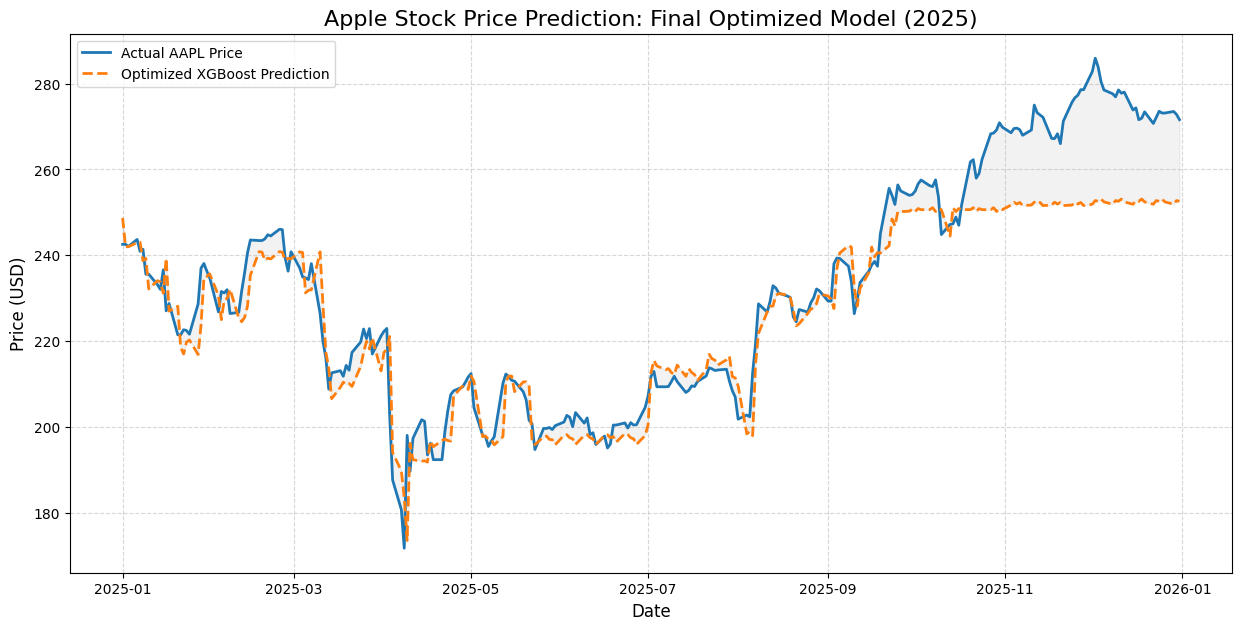

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# رسم السعر الحقيقي
plt.plot(y_test_xgboost.index, y_test_xgboost.values, label='Actual AAPL Price', color='#1f77b4', linewidth=2)

# رسم توقعات الموديل المحسن
plt.plot(y_test_xgboost.index, final_predictions, label='Optimized XGBoost Prediction', color='#ff7f0e', linestyle='--', linewidth=2)

plt.title('Apple Stock Price Prediction: Final Optimized Model (2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# إضافة منطقة تظليل لتوضيح الفرق (Error Gap)
plt.fill_between(y_test_xgboost.index, y_test_xgboost.values, final_predictions, color='gray', alpha=0.1, label='Error Margin')

plt.show()

<Figure size 1000x800 with 0 Axes>

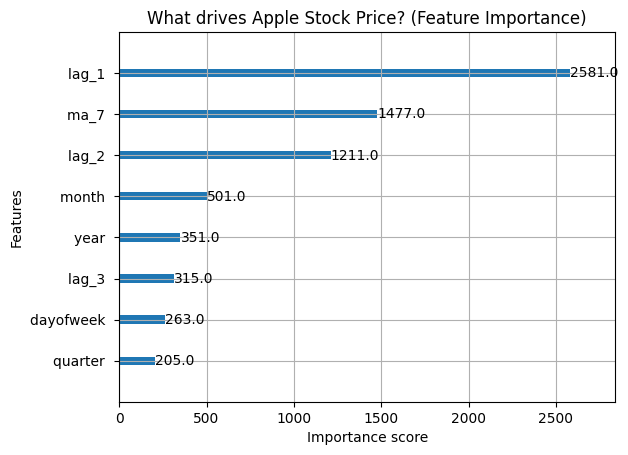

In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_regressor, importance_type='weight', max_num_features=10)
plt.title('What drives Apple Stock Price? (Feature Importance)')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary of your results
results_data = {
    'Model': ['LSTM', 'Rolling Window', 'Sliding Window', 'XGBoost (Optuna)','Prophet'],
    'RMSE': [RMSE_LSTM, RMSE_Expanding_window, RMSE_Rolling_window, RMSE_XGBOOST,RMSE_Prophet]
}

# Create DataFrame
df_comparison = pd.DataFrame(results_data)

# Sort by RMSE (Lower is better)
df_comparison = df_comparison.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print("Model Comparison Table:")
print(df_comparison)

Model Comparison Table:
              Model       RMSE
0              LSTM   9.763696
1  XGBoost (Optuna)  10.611179
2           Prophet  26.077025
3    Sliding Window  30.453051
4    Rolling Window  57.847767


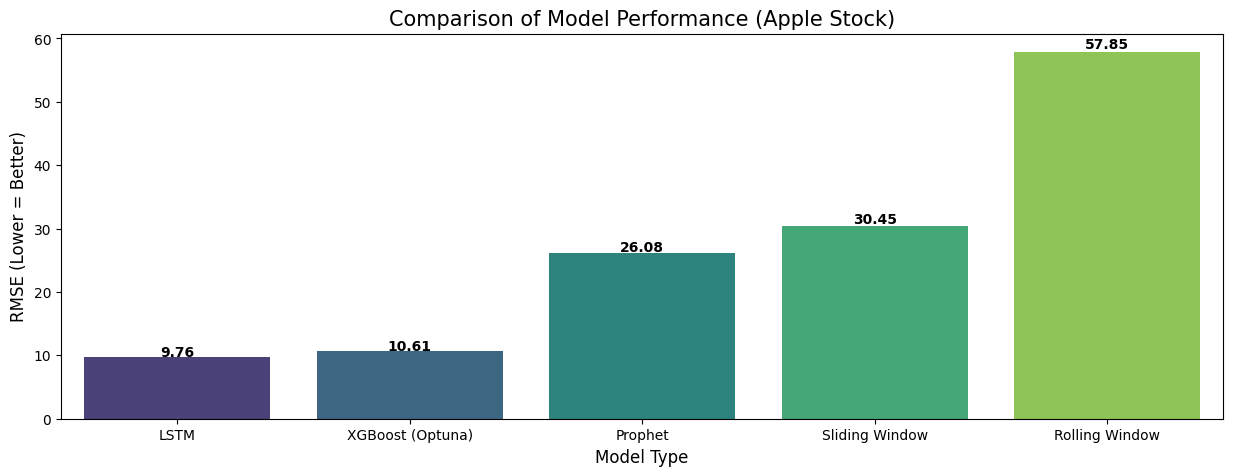

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='Model', y='RMSE', data=df_comparison, palette='viridis')

# Add labels and title
plt.title('Comparison of Model Performance (Apple Stock)', fontsize=15)
plt.ylabel('RMSE (Lower = Better)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)

# Annotate the exact RMSE values on top of bars
for i, val in enumerate(df_comparison['RMSE']):
    plt.text(i, val + (val*0.01), f'{val:.2f}', ha='center', fontweight='bold')

plt.show()